## <center> A Study on the Effect of Socioeconomic factors on Child Mortality (< 5 years of age) </center>

This Jupyter Notebook will host all the calculations and data rendering that has been done to discuss the results in the PDF report. 

<a id='contents'></a>
## Table of Contents
- [Introduction](#intro)
- [Data Transformations](#data_transformation)
- [Dealing with Missing Data](#missing_data)
- [Data Pre-processing](#data_preprocessing)
- [Exploratory Data Analysis](#data_exploration)
- [Normality Check of the dependent variable](#normality_check)
- [Data Comparison across countries](#data_comparison)
- [Regression Analysis](#regression)
- [Analysis of Residuals](#residual_analysis)
- [Implications and Conclusion](#conclusion)

<a id='intro'></a>
## Introduction 
[Back to table of contents](#contents)

The data that has been used in this study has been taken from [World Bank](https://databank.worldbank.org/home.aspx) and is stored in the file **Data_Extract_From_World_Development_Indicators.xlsx**. The data collected is for all the countries for the indicators mentioned in the PDF report. The goal is to use the data from all countries in order to run the regression algorithm and then interpret the results and share insights for the 4 countries that are chosen in this study.

Before we proceed with any code, we first import all the libraries that we will be using in the future.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from patsy import dmatrices
from statsmodels.stats.outliers_influence import variance_inflation_factor
from scipy.stats import shapiro
import statsmodels.stats.api as sms
from statsmodels.compat import lzip
import statsmodels.api as sm

%matplotlib inline

<a id='data_transformation'></a>
## Data Transformations
[Back to table of contents](#contents)

Before we proceed with our analysis of the data, we need to do some Data wrangling and transformations to represent the data in the desirable form. We will discuss these one by one below

### 1. Transformation of Rows and Columns

The data extracted from World Bank has the Years in the columns and the indicator values in the rows. We will transform this into the indicators in the columns and the Years (Time series) in the rows. In order to do this we have made use of a python library called [pandas](https://pandas.pydata.org/) which is a data analysis and manipulation tool that represents our data in what we call Data Frames.
The python code used to perform this transformation is given below

In [2]:
data = pd.read_excel("Data_Extract_From_World_Development_Indicators.xlsx", sheet_name="Data")
income_level_data = pd.read_excel("Income_Categories.xlsx", sheet_name="Metadata - Countries")

def clean_data(df):
    '''
    Take a DataFrame that represents a given country, transpose it, rename the indices
    create a country column, delete the country and series rows.
    '''
    df = df.transpose()
    df.columns = df.iloc[1]
    
    country = df.iloc[0, 0]

    df = df.drop(df.index[0])
    df = df.drop(df.index[0])

    df["Country"] = country
    return df


df = pd.DataFrame()

# 264 countries in the dataset 
for i in range(264):
    df = df.append(clean_data(data[i*10:(i+1)*10]))

df['IncomeGroup'] = ""

for c in df["Country"].unique():
    if income_level_data[income_level_data["Country"] == c]['IncomeGroup'].any():
        df.loc[df["Country"] == c, 'IncomeGroup'] = income_level_data[income_level_data["Country"] == c]['IncomeGroup'].values[0]
    else:
        df.loc[df["Country"] == c, 'IncomeGroup'] = "NA"

df
df.to_excel("Clean_Data.xlsx")

### 2. Calculation of Net ODA received from Net ODA provided

Net official development assistance (ODA) consists of loans and grants that are recieved by nations to support their economy. Certian countries (mostly high income countries) do not have any Net ODA receieved. However, they are involved in providing assistance to other developing nations. The World Bank data for some countries refelcts a negative value for Net ODA receieved and for other countries has no values for Net ODA received but on the other hand has values for Net ODA provided to other countries. We will combine this data and represent this in a single variable under Net ODA received by subtracting the Net ODA provided. This way, we will have a standardized representation of data. The reference of this can be found [here](https://datahelpdesk.worldbank.org/knowledgebase/articles/114966-why-do-some-countries-receive-negative-amounts-of#:~:text=Aid%20and%20aid%20per%20capita,aid%20provided%20to%20other%20countries)

This calculation is done in excel and the results are stored directly in the workbook.

### 3. Data Cleaning

For the python libraries to work with the data, there are some cleaning activities that need to be performed.
1) The **Year** column is cleaned to represent only numbers

2) The empty values where data is not found is replaced with empty cells instead of '..'

The output data is stored in the file **Clean_Data.xlsx**

<a id='missing_data'></a>
## Dealing with Missing Data
[Back to table of contents](#contents)

Before we proceed with the calculation of the statistics for the given data, we see that we have some missing data points in our dataset and we have to deal with them. There are broadly 2 ways in which we can deal with missing data
> Drop missing data

> Data Imputation

**Data Imputation** is the process of filling the missing data and there are various techniques to do so (One of them is to calculate the mean value of the rest of the available scores of the variable and fill the missing entries with the calculated mean). This approach is fine if the variables under consideration have no relationship between them and if we do not intend to perform any correlational study between variables. 
In our case, the best approach would be to dropping missing data would be the best approach

There are 2 kinds of missing data that are present in our dataset.

### 1. Missing Data as per Indices

Regression algorithms require data to be available for all the indices in a given sample. We have many years where we do not have the data for a few indices. We will drop such data points as shown below

In [3]:
data = pd.read_excel("Clean_Data.xlsx", sheet_name="Data")

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16104 entries, 0 to 16103
Data columns (total 12 columns):
 #   Column                                                               Non-Null Count  Dtype  
---  ------                                                               --------------  -----  
 0   Year                                                                 16104 non-null  int64  
 1   Country                                                              16104 non-null  object 
 2   IncomeGroup                                                          15860 non-null  object 
 3   Mortality rate, under-5 (per 1,000 live births)                      11835 non-null  float64
 4   Population growth (annual %)                                         15407 non-null  float64
 5   Fertility rate, total (births per woman)                             14262 non-null  float64
 6   Age dependency ratio (% of working-age population)                   14329 non-null  float64
 7   GDP 

The column names are descriptions of the indicators. We shall rename the column names for easier access

In [5]:
data = data.rename(columns={'Mortality rate, under-5 (per 1,000 live births)': 'Mortality', 
                        'Population growth (annual %)': 'Population_Growth',
                       'Fertility rate, total (births per woman)':'Fertility',
                       'Age dependency ratio (% of working-age population)':'Age_Dependency',
                       'GDP per capita (current US$)':'GDP',
                       'Inflation, consumer prices (annual %)':'Inflation',
                       'Net ODA received (% of GNI)':'Net_ODA',
                       'Unemployment, total (% of total labor force) (modeled ILO estimate)':'Unemployment',
                       'Adjusted savings: education expenditure (% of GNI)':'Education_Expenditure'})

In [6]:
data_filtered = data.dropna()

In [7]:
data_filtered.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4809 entries, 49 to 16101
Data columns (total 12 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Year                   4809 non-null   int64  
 1   Country                4809 non-null   object 
 2   IncomeGroup            4809 non-null   object 
 3   Mortality              4809 non-null   float64
 4   Population_Growth      4809 non-null   float64
 5   Fertility              4809 non-null   float64
 6   Age_Dependency         4809 non-null   float64
 7   GDP                    4809 non-null   float64
 8   Inflation              4809 non-null   float64
 9   Net_ODA                4809 non-null   float64
 10  Unemployment           4809 non-null   float64
 11  Education_Expenditure  4809 non-null   float64
dtypes: float64(9), int64(1), object(2)
memory usage: 488.4+ KB


### 1. Missing Data as per Countries

There are certain entries where data is available for some countries and for some countries its not. This causes a bias in the estimate of statistics measures such as mean, median and so on. For example, if the GDP for a high income country is available for 40 years and for a low income country it is only avaiable for 20 years, calculating the mean value of GDP for the high income country for all 40 years will induce a bias.

We handle the missing data as per country for the 4 countries we have considered as shown below

In [8]:
years = np.arange(1960,2020,1)
data_filtered_Canada = data_filtered[data_filtered['Country']=='Canada']
data_filtered_Indonesia = data_filtered[data_filtered['Country']=='Indonesia']
data_filtered_India = data_filtered[data_filtered['Country']=='India']
data_filtered_Sudan = data_filtered[data_filtered['Country']=='Sudan']
available_years = []
for i in years:
    if i in data_filtered_Canada.Year.unique() and i in data_filtered_Indonesia.Year.unique() and i in data_filtered_India.Year.unique() and i in data_filtered_Sudan.Year.unique():
        available_years.append(i)
data_filtered = data_filtered[data_filtered.Year.isin(available_years)]

In [9]:
data_filtered.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4521 entries, 49 to 16099
Data columns (total 12 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Year                   4521 non-null   int64  
 1   Country                4521 non-null   object 
 2   IncomeGroup            4521 non-null   object 
 3   Mortality              4521 non-null   float64
 4   Population_Growth      4521 non-null   float64
 5   Fertility              4521 non-null   float64
 6   Age_Dependency         4521 non-null   float64
 7   GDP                    4521 non-null   float64
 8   Inflation              4521 non-null   float64
 9   Net_ODA                4521 non-null   float64
 10  Unemployment           4521 non-null   float64
 11  Education_Expenditure  4521 non-null   float64
dtypes: float64(9), int64(1), object(2)
memory usage: 459.2+ KB


<a id='data_exploration'></a>
## Exploratory Data Analysis
[Back to table of contents](#contents)

Now that our data is clean, we will import the data and perform some exploratory data analysis to understand our data better.
First, we will import the data from the excel into a pandas dataframe as shown below.

In [10]:
data_filtered.describe()

Year    Mortality  Population_Growth    Fertility  \
count  4521.000000  4521.000000        4521.000000  4521.000000   
mean   2003.942933    53.532697           1.544805     3.262382   
std       7.374425    49.657467           1.133552     1.604922   
min    1991.000000     2.200000          -9.080638     1.076000   
25%    1998.000000    15.065302           0.711426     1.885435   
50%    2004.000000    34.807116           1.480133     2.799000   
75%    2010.000000    83.700000           2.430732     4.504538   
max    2016.000000   322.200000           8.117928     8.459000   

       Age_Dependency            GDP     Inflation      Net_ODA  Unemployment  \
count     4521.000000    4521.000000   4521.000000  4521.000000   4521.000000   
mean        66.025037    8571.371760     16.328808     4.031508      7.644355   
std         18.209114   14302.887171    361.693243     7.163795      5.621252   
min         32.634060     102.597978    -60.496401    -2.312579      0.300000   
25%         50.530601     869.741254      2.424437     0.084098      3.951000   
50%         61.431739    2649.618144      4.578086     0.992133      6.050000   
75%         81.645545    8474.586829      8.331897     5.433915      9.868000   
max        117.467702  118823.648369  23773.131774    92.141460     37.976002   

       Education_Expenditure  
count            4521.000000  
mean                3.885882  
std                 1.523358  
min                 0.300000  
25%                 2.840000  
50%                 3.796267  
75%                 4.751316  
max                 9.940000

The above statistics are for all the countries combined. However, we are interested in describing the data for individual countries. We will also extract the data of the indices that are calculated for groups of countries such as High Income countries, Low income countries and so on. This data is provided by World Bank. We do that as follows

In [11]:
data_filtered[data_filtered['Country']=='Canada'].describe()

Year  Mortality  Population_Growth  Fertility  Age_Dependency  \
count    26.000000  26.000000          26.000000  26.000000       26.000000   
mean   2003.500000   6.203846           1.020935   1.592796       46.049317   
std       7.648529   0.739990           0.116250   0.068858        1.437661   
min    1991.000000   5.200000           0.746339   1.488000       43.933903   
25%    1997.250000   5.625000           0.951134   1.532825       44.694298   
50%    2003.500000   6.100000           1.040041   1.586600       46.193631   
75%    2009.750000   6.475000           1.093306   1.653925       47.422010   
max    2016.000000   8.000000           1.242761   1.710000       47.826314   

                GDP  Inflation    Net_ODA  Unemployment  Education_Expenditure  
count     26.000000  26.000000  26.000000     26.000000              26.000000  
mean   33543.423676   1.921693  -0.316731      8.006731               5.399217  
std    12416.738841   1.018875   0.067482      1.533079               0.866466  
min    19935.381458   0.165563  -0.459000      6.036000               4.380000  
25%    21783.565832   1.496519  -0.336750      6.935250               4.878567  
50%    30117.482909   1.861169  -0.299500      7.542500               4.946067  
75%    44303.658772   2.247184  -0.275500      8.911750               5.946451  
max    52678.390123   5.625864  -0.217000     11.377000               7.100000

In [12]:
data_filtered[data_filtered['Country']=='Indonesia'].describe()

Year  Mortality  Population_Growth  Fertility  Age_Dependency  \
count    26.000000  26.000000          26.000000  26.000000       26.000000   
mean   2003.500000  48.026923           1.407166   2.561692       54.879302   
std       7.648529  16.180125           0.131455   0.161263        5.119473   
min    1991.000000  26.700000           1.219766   2.362000       48.714408   
25%    1997.250000  34.250000           1.331261   2.485250       51.087170   
50%    2003.500000  46.550000           1.350367   2.511500       53.564016   
75%    2009.750000  59.400000           1.444238   2.570250       58.057364   
max    2016.000000  80.200000           1.736904   3.022000       65.933693   

               GDP  Inflation    Net_ODA  Unemployment  Education_Expenditure  
count    26.000000  26.000000  26.000000     26.000000              26.000000  
mean   1756.613602   9.986652   0.591588      5.328808               1.965280  
std    1164.723222  10.525634   0.563993      1.606502               1.034251  
min     463.948169   3.525805  -0.044363      2.540000               0.485183  
25%     845.973373   6.104580   0.074275      4.309750               0.756264  
50%    1143.835717   7.140417   0.429468      5.306500               2.193549  
75%    2907.083917  10.087972   0.936672      6.528000               2.860000  
max    3694.348946  58.451044   1.648753      8.060000               3.270000

In [13]:
data_filtered[data_filtered['Country']=='India'].describe()

Year   Mortality  Population_Growth  Fertility  Age_Dependency  \
count    26.000000   26.000000          26.000000  26.000000       26.000000   
mean   2003.500000   80.457692           1.602092   3.065769       61.364079   
std       7.648529   25.546243           0.300847   0.534003        6.397534   
min    1991.000000   40.900000           1.089880   2.266000       50.888137   
25%    1997.250000   59.000000           1.365400   2.601000       56.210323   
50%    2003.500000   79.500000           1.633399   3.075000       61.285389   
75%    2009.750000  101.700000           1.861794   3.497000       66.836045   
max    2016.000000  122.700000           2.039730   3.959000       71.309032   

               GDP  Inflation    Net_ODA  Unemployment  Education_Expenditure  
count    26.000000  26.000000  26.000000     26.000000              26.000000  
mean    812.453481   7.693873   0.318808      5.591231               3.290118  
std     491.414482   3.198018   0.244329      0.111035               0.381410  
min     301.159004   3.767252   0.093117      5.281000               2.900000  
25%     413.847650   4.737622   0.148349      5.565250               3.080000  
50%     587.250431   6.768567   0.207248      5.633500               3.090000  
75%    1293.662999  10.242173   0.395730      5.657250               3.375000  
max    1732.564262  13.870246   1.027657      5.725000               4.290000

In [14]:
data_filtered[data_filtered['Country']=='Sudan'].describe()

Year   Mortality  Population_Growth  Fertility  Age_Dependency  \
count    26.000000   26.000000          26.000000  26.000000       26.000000   
mean   2003.500000   94.169231           2.622975   5.277577       87.373067   
std       7.648529   20.839631           0.506150   0.477749        2.983520   
min    1991.000000   64.100000           2.140713   4.532000       80.758716   
25%    1997.250000   75.950000           2.325989   4.888500       86.192480   
50%    2003.500000   92.000000           2.406775   5.236000       87.768442   
75%    2009.750000  112.350000           2.596368   5.668000       89.086337   
max    2016.000000  128.400000           3.779960   6.091000       93.003616   

               GDP   Inflation    Net_ODA  Unemployment  Education_Expenditure  
count    26.000000   26.000000  26.000000     26.000000              26.000000  
mean    826.521721   38.481990   3.699162     15.693500               1.759689  
std     528.194203   42.479583   2.248145      1.064030               0.504135  
min     260.510244    4.871467   1.225602     13.000000               0.868476  
25%     379.970006    8.442688   1.931540     15.222250               1.327500  
50%     529.075831   17.007256   2.982068     15.404000               2.063452  
75%    1303.215087   44.214403   5.093206     15.535750               2.180000  
max    1909.738755  132.823777   8.866860     17.499001               2.180000

In [15]:
data_filtered[data_filtered['Country']=='High income'].describe()

Year  Mortality  Population_Growth  Fertility  Age_Dependency  \
count    26.000000  26.000000          26.000000  26.000000       26.000000   
mean   2003.500000   7.834615           0.656147   1.700585       49.566897   
std       7.648529   2.065515           0.089154   0.044791        0.870350   
min    1991.000000   5.300000           0.457310   1.650104       48.521418   
25%    1997.250000   6.150000           0.592789   1.667574       48.826946   
50%    2003.500000   7.400000           0.636779   1.690065       49.534874   
75%    2009.750000   9.100000           0.721481   1.713843       50.129539   
max    2016.000000  12.400000           0.839727   1.824757       51.822734   

                GDP  Inflation    Net_ODA  Unemployment  Education_Expenditure  
count     26.000000  26.000000  26.000000     26.000000              26.000000  
mean   31054.319228   2.521786   0.004864      7.071650               4.461936  
std     8087.234747   1.160265   0.005962      0.690237               0.153755  
min    19344.990298   0.319696   0.000202      5.612534               4.129145  
25%    24285.298006   1.956785   0.001026      6.637739               4.390159  
50%    30044.204434   2.553588   0.001610      7.081386               4.495812  
75%    39460.725913   2.839219   0.007466      7.728713               4.566625  
max    42293.544512   5.295415   0.017936      8.203682               4.751731

In [16]:
data_filtered[data_filtered['Country']=='Upper middle income'].describe()

Year  Mortality  Population_Growth  Fertility  Age_Dependency  \
count    26.000000  26.000000          26.000000  26.000000       26.000000   
mean   2003.500000  31.907692           0.956390   1.992081       48.823235   
std       7.648529  12.412185           0.206053   0.162890        5.741010   
min    1991.000000  15.200000           0.769296   1.889060       42.854019   
25%    1997.250000  20.825000           0.801206   1.895841       43.356229   
50%    2003.500000  30.600000           0.836831   1.911523       47.130553   
75%    2009.750000  42.225000           1.115691   2.001431       53.809503   
max    2016.000000  53.300000           1.460757   2.508885       58.874283   

               GDP  Inflation    Net_ODA  Unemployment  Education_Expenditure  
count    26.000000  26.000000  26.000000     26.000000              26.000000  
mean   3782.977775   6.716955   0.188773      5.542150               3.286744  
std    2558.418878   4.423213   0.091856      0.701488               0.100527  
min    1305.522843   1.896174   0.062086      3.877045               3.020129  
25%    1812.702427   3.985953   0.093656      5.412029               3.245414  
50%    2289.172580   5.287184   0.201103      5.714616               3.281679  
75%    5869.886003   8.006769   0.246960      5.945647               3.331256  
max    8258.437751  21.565624   0.424903      6.456054               3.453520

In [17]:
data_filtered[data_filtered['Country']=='Lower middle income'].describe()

Year   Mortality  Population_Growth  Fertility  Age_Dependency  \
count    26.000000   26.000000          26.000000  26.000000       26.000000   
mean   2003.500000   86.692308           1.777277   3.451043       67.187976   
std       7.648529   21.926293           0.221233   0.460030        6.063750   
min    1991.000000   54.100000           1.483494   2.820098       58.433319   
25%    1997.250000   67.450000           1.606009   3.063205       61.885829   
50%    2003.500000   85.650000           1.723002   3.388647       66.637237   
75%    2009.750000  105.875000           1.953158   3.792582       72.469224   
max    2016.000000  121.700000           2.209729   4.331112       77.024365   

               GDP  Inflation    Net_ODA  Unemployment  Education_Expenditure  
count    26.000000  26.000000  26.000000     26.000000              26.000000  
mean    994.445723   6.688841   1.598099      5.103386               3.420450  
std     563.708567   2.940683   0.687043      0.256918               0.238304  
min     431.488653   3.219887   0.794213      4.574502               3.142421  
25%     535.942001   4.508142   1.048579      4.892095               3.217848  
50%     703.800936   5.503859   1.554789      5.099335               3.313464  
75%    1487.334717   9.098295   1.705297      5.330795               3.624950  
max    1935.239874  13.224266   3.344753      5.474352               3.803112

In [18]:
data_filtered[data_filtered['Country']=='Low income'].describe()

Year   Mortality  Population_Growth  Fertility  Age_Dependency  \
count    26.000000   26.000000          26.000000  26.000000       26.000000   
mean   2003.500000  126.030769           2.779278   5.678236       91.876101   
std       7.648529   34.863480           0.137114   0.513544        2.610755   
min    1991.000000   74.700000           2.543851   4.761623       85.843959   
25%    1997.250000   96.125000           2.706590   5.266696       90.399483   
50%    2003.500000  124.150000           2.812402   5.738164       92.787046   
75%    2009.750000  157.450000           2.876944   6.123770       93.988281   
max    2016.000000  179.500000           2.993388   6.395848       94.535415   

              GDP  Inflation    Net_ODA  Unemployment  Education_Expenditure  
count   26.000000  26.000000  26.000000     26.000000              26.000000  
mean   488.728278   8.425404  10.638941      4.959311               2.653572  
std    231.001026   6.183916   2.271306      0.252348               0.250537  
min    244.452029   3.194909   7.048398      4.322110               2.197534  
25%    292.691567   5.128412   9.342387      4.860330               2.458355  
50%    362.417921   6.851213   9.890808      5.044896               2.699334  
75%    720.528362   8.879184  11.788342      5.123415               2.858124  
max    883.969992  34.649636  16.515431      5.250765               2.965793

In [19]:
data_filtered[data_filtered['Country']=='World'].describe()

Year  Mortality  Population_Growth  Fertility  Age_Dependency  \
count    26.000000  26.000000          26.000000  26.000000       26.000000   
mean   2003.500000  66.726923           1.319560   2.671667       58.507677   
std       7.648529  16.944393           0.146769   0.196809        4.053786   
min    1991.000000  41.300000           1.162528   2.445519       54.000509   
25%    1997.250000  51.675000           1.208260   2.520834       54.591738   
50%    2003.500000  66.600000           1.257870   2.616684       57.587096   
75%    2009.750000  82.200000           1.418453   2.769372       62.110273   
max    2016.000000  91.700000           1.666437   3.157393       65.360345   

                GDP  Inflation    Net_ODA  Unemployment  Education_Expenditure  
count     26.000000  26.000000  26.000000     26.000000              26.000000  
mean    7306.909490   4.797930   0.191120      5.667541               4.189436  
std     2330.469560   2.483672   0.026297      0.341021               0.146893  
min     4464.654312   1.393330   0.145109      4.757762               3.954202  
25%     5396.180111   3.035357   0.175652      5.580848               4.087178  
50%     6475.919210   3.995561   0.192317      5.731760               4.164888  
75%     9519.441053   6.297232   0.206282      5.889502               4.288933  
max    10952.344419  10.143683   0.254847      6.188569               4.548369

### Plotting the Data

In order to better understand our data, we will create some plots as shown below. We make use of python libraries [matplotlib](https://matplotlib.org/) and [seaborn](https://seaborn.pydata.org/) to do this.

First we create a box and whiskers plot that will help us better understand the distribution of the indices across countries

In [20]:
variables = ['Mortality','Population_Growth','Fertility','Age_Dependency','GDP','Inflation','Net_ODA','Unemployment','Education_Expenditure']
label_names = ['Mortality rate, under-5 (per 1,000 live births)',
                'Population growth (annual %)',
                'Fertility rate, total (births per woman)',
                'Age dependency ratio (% of working-age population)',
                'GDP per capita (current US$)',
                'Inflation, consumer prices (annual %)',
                'Net ODA received (% of GNI)',
                'Unemployment, total (% of total labor force) (modeled ILO estimate)',
                'Adjusted savings: education expenditure (% of GNI)']
countries = ['Canada','Indonesia','India','Sudan','High income','Upper middle income','Lower middle income','Low income','World']

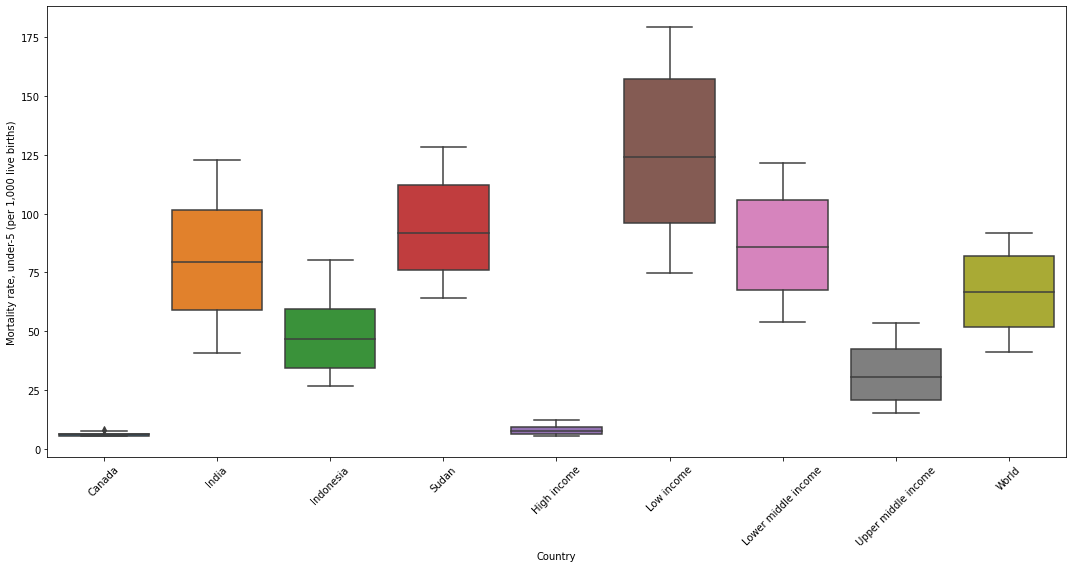

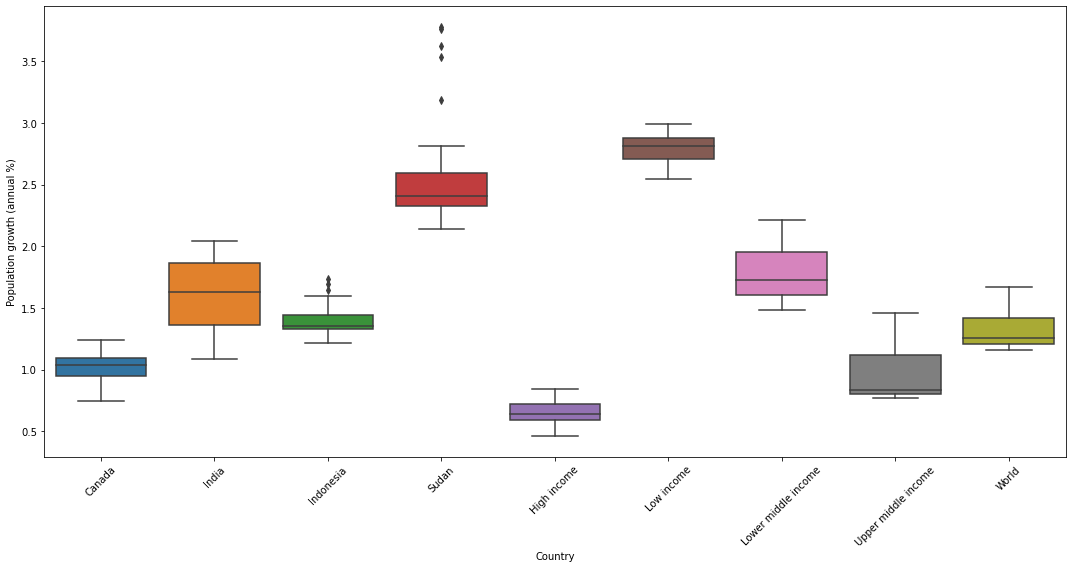

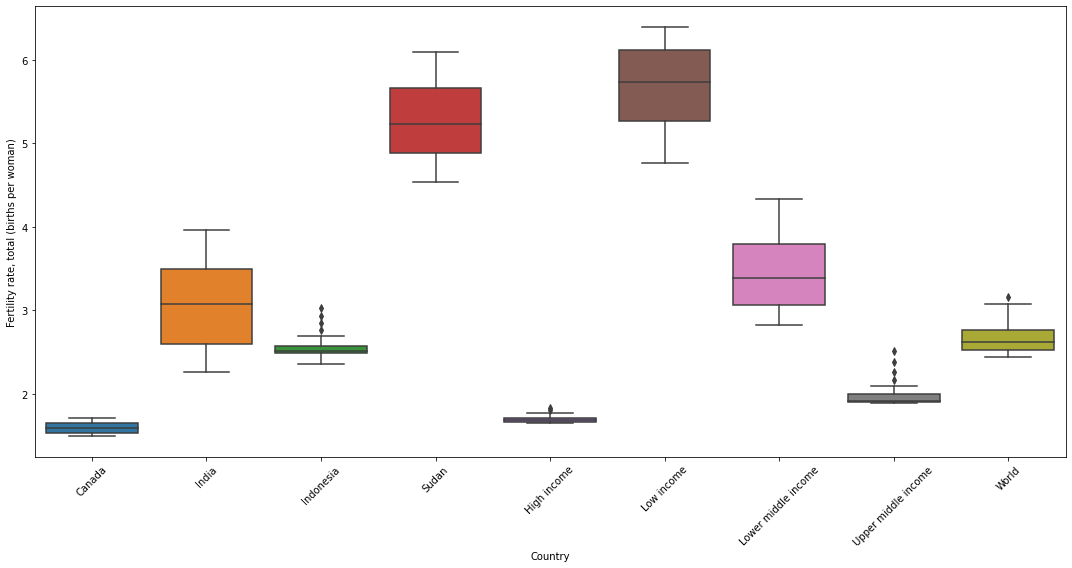

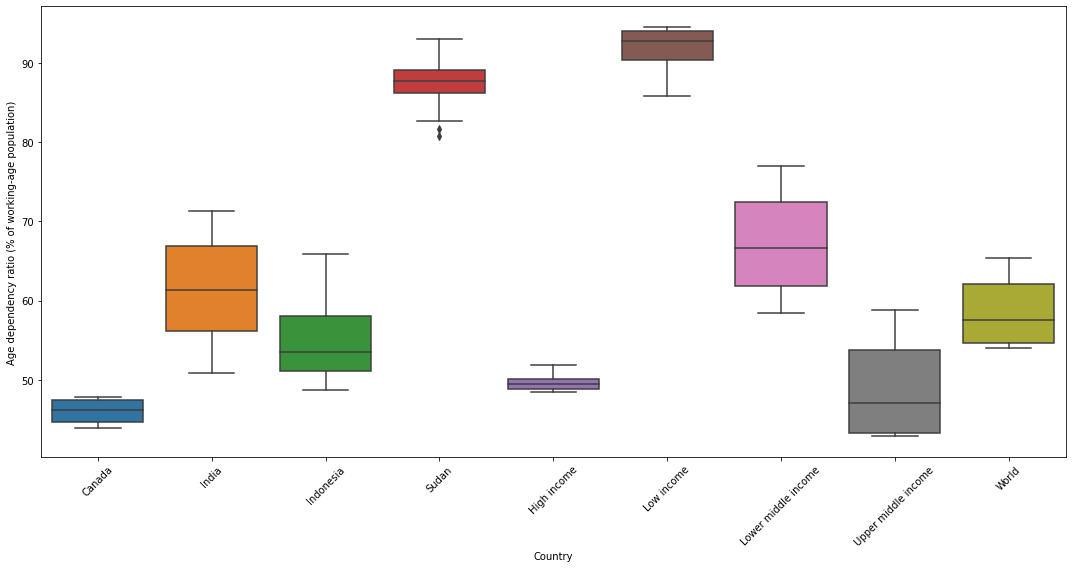

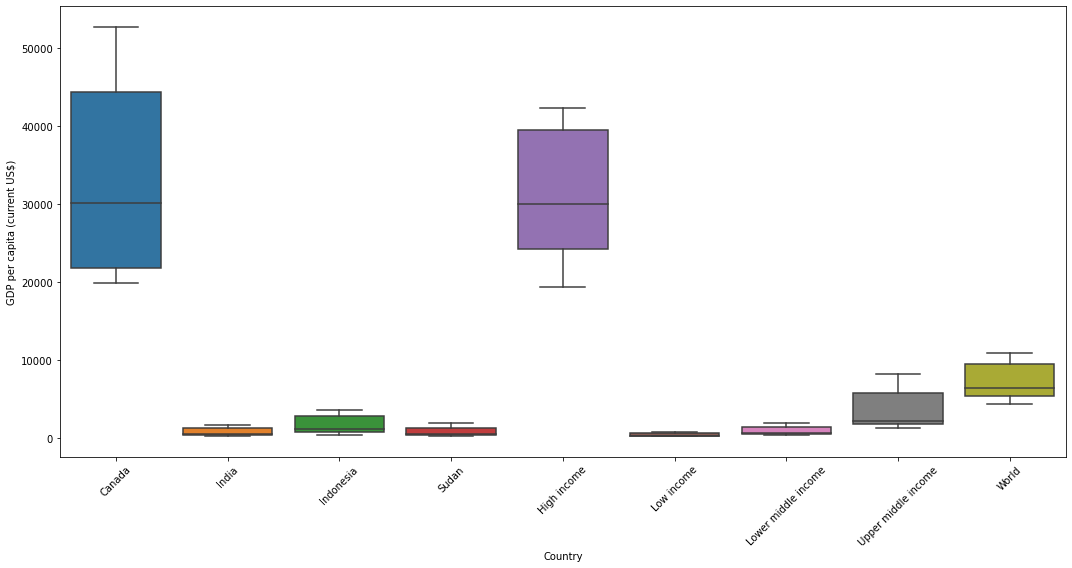

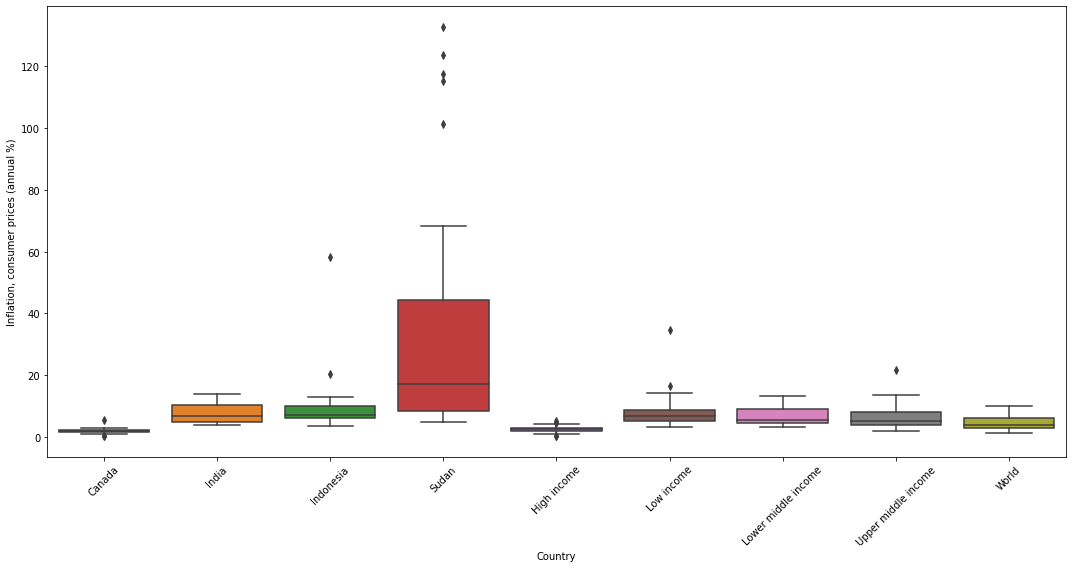

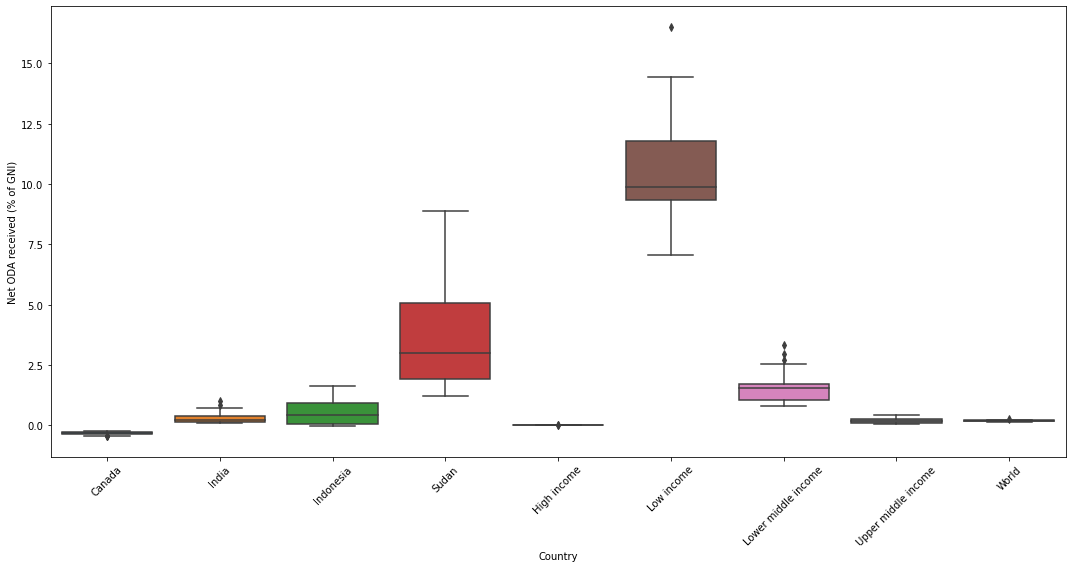

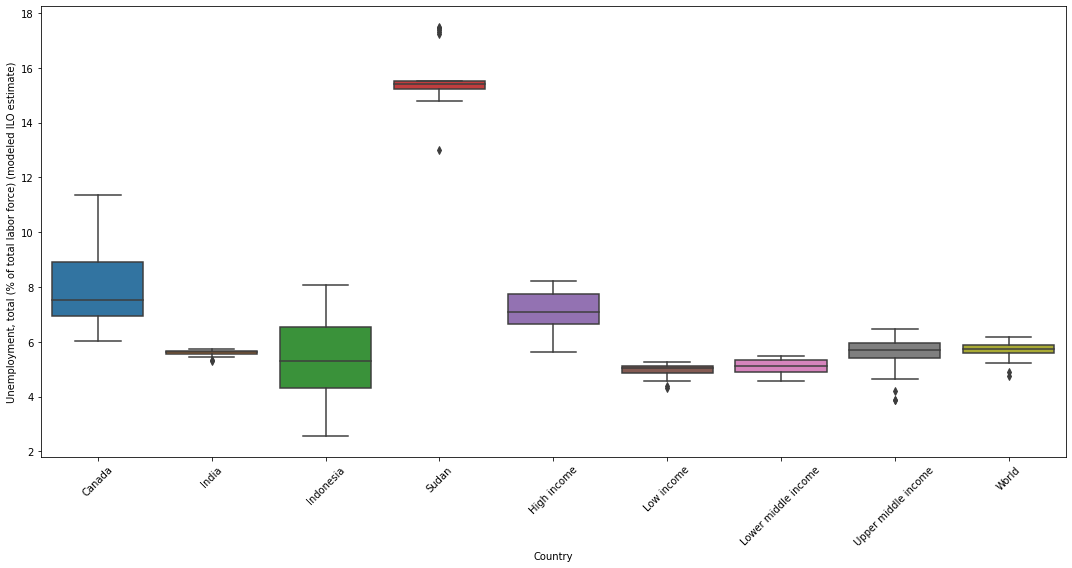

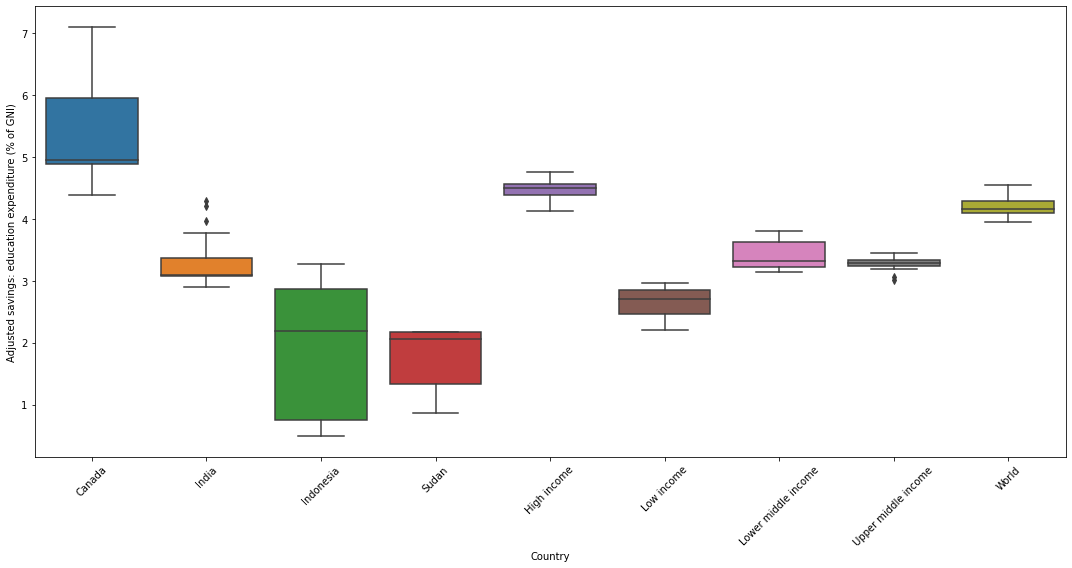

In [21]:
df = data_filtered[data_filtered['Country'].isin(countries)]
for i in range(0,len(variables)):
    plt.figure(figsize=(15, 8))
    sns.boxplot(x="Country", y=variables[i], data=df);
    plt.xticks(rotation=45);
    plt.ylabel(label_names[i])
    plt.tight_layout()
    plt.savefig(str(variables[i]) + '_boxplot' + '.jpg')

Next, we plot the histograms for the indvidual indices for all countries under consideration. We also mark the mean and median values in the histograms

C:\Users\Manthan\.conda\envs\msci609\lib\site-packages\ipykernel_launcher.py:6: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


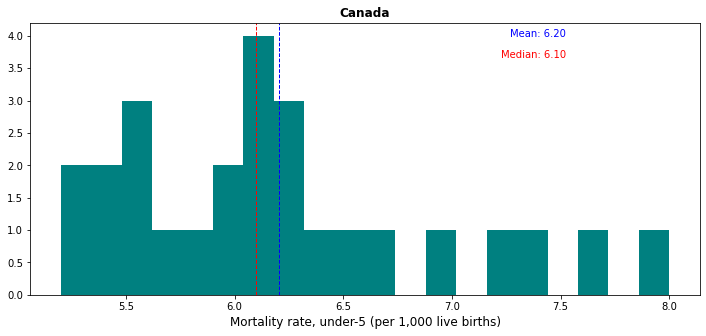

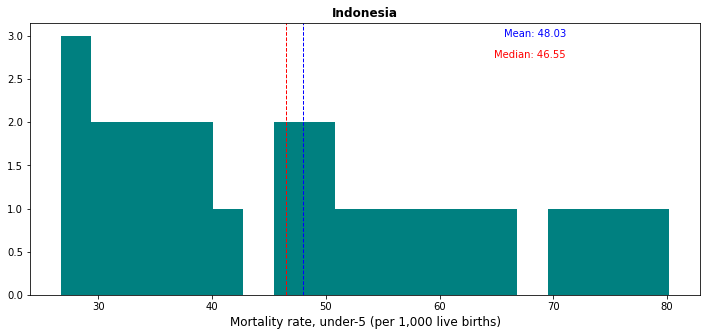

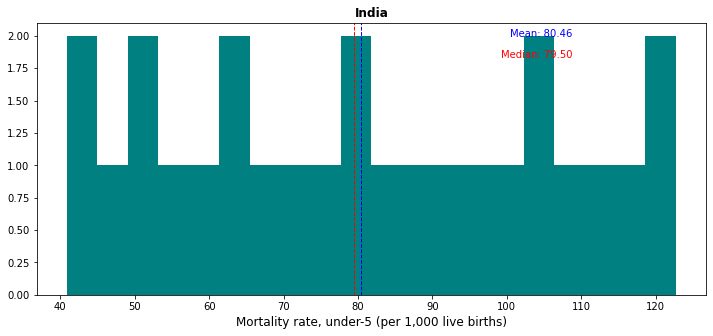

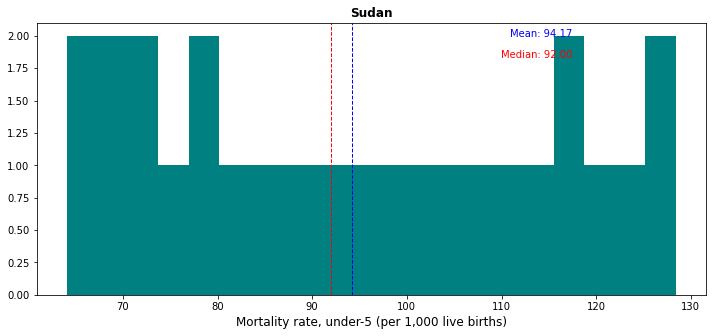

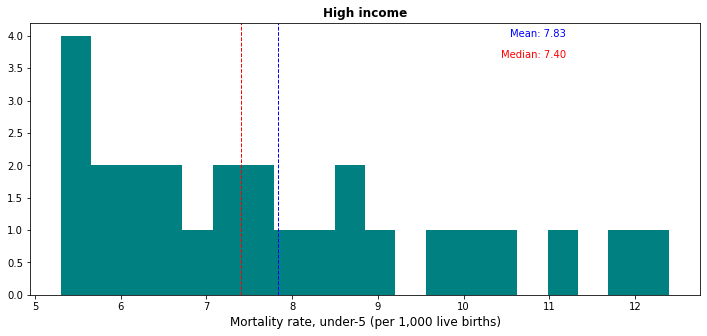

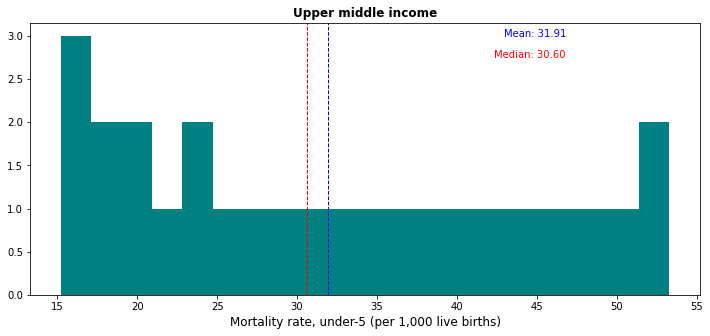

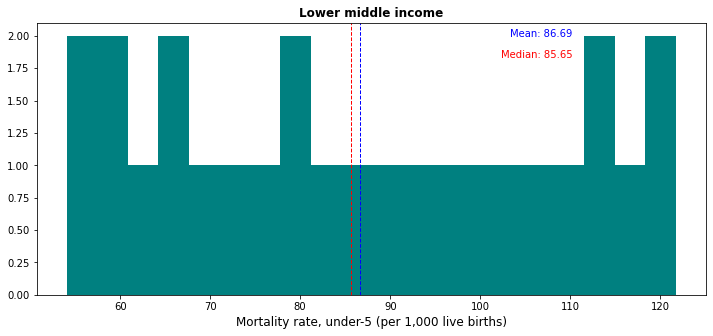

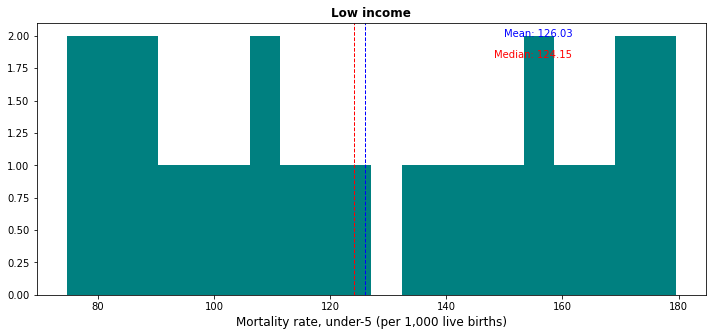

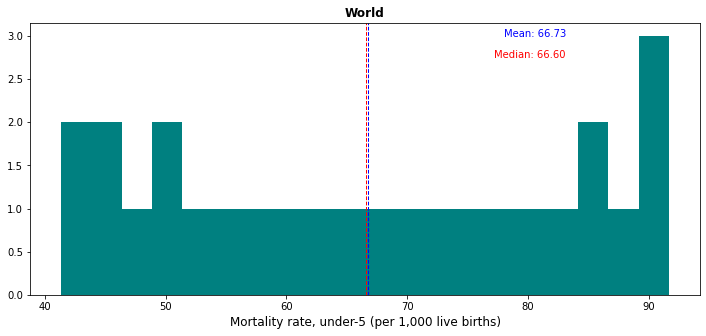

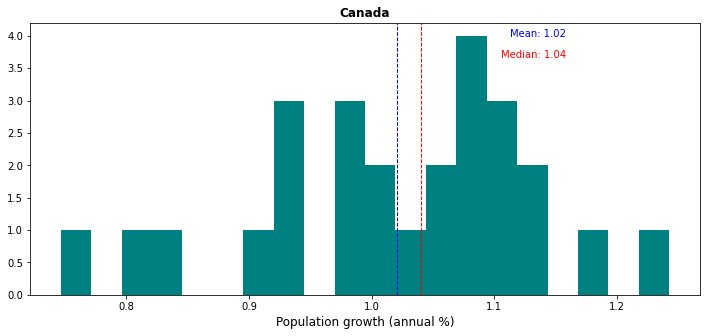

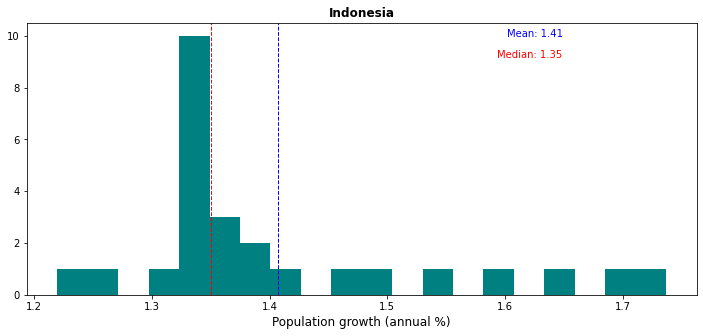

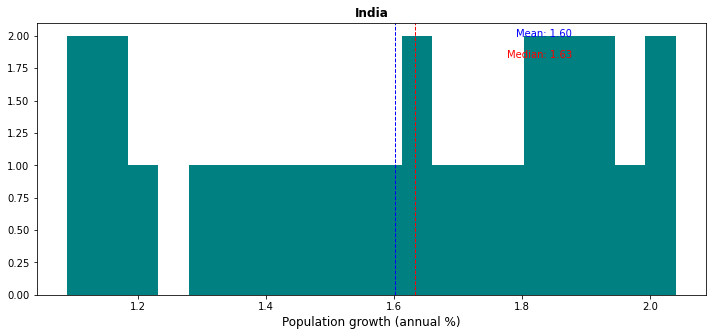

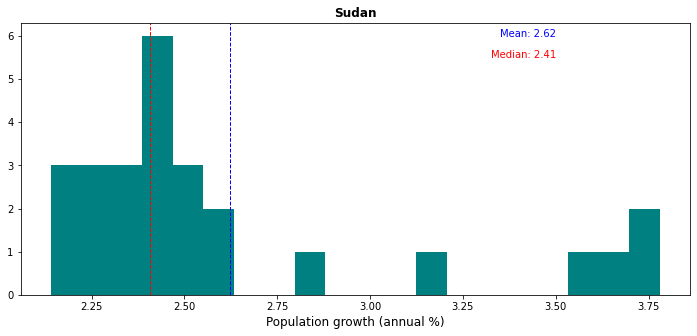

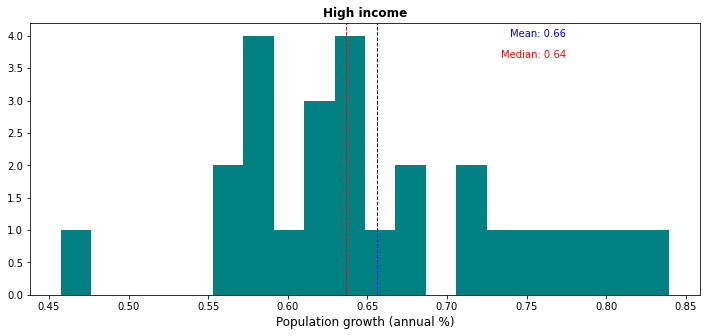

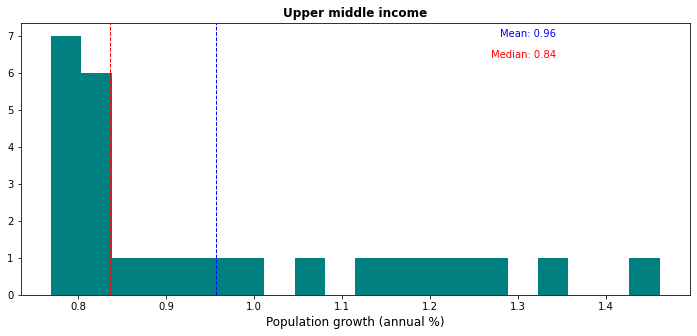

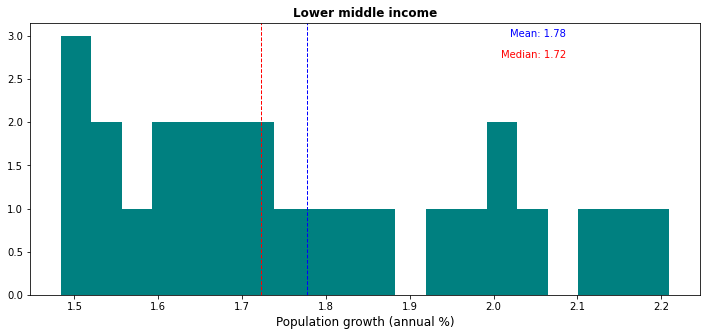

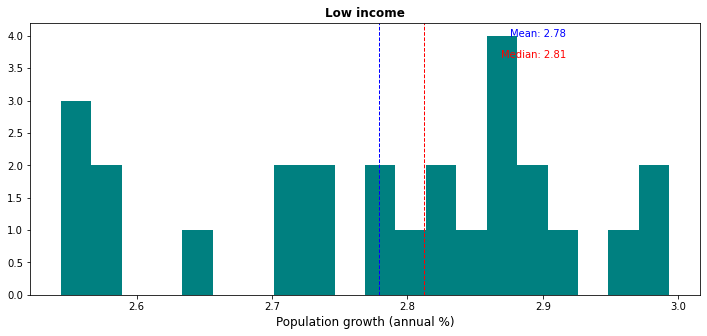

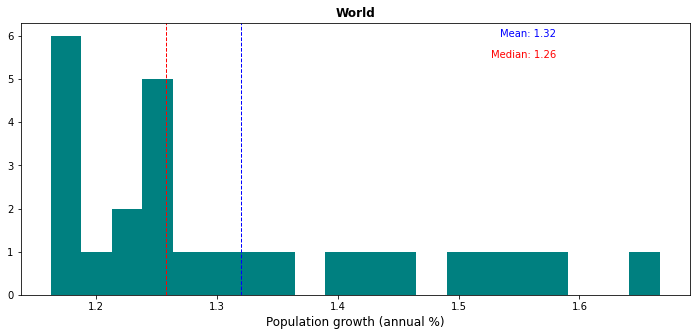

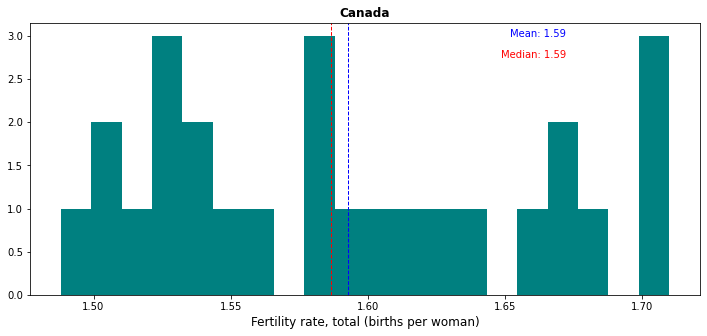

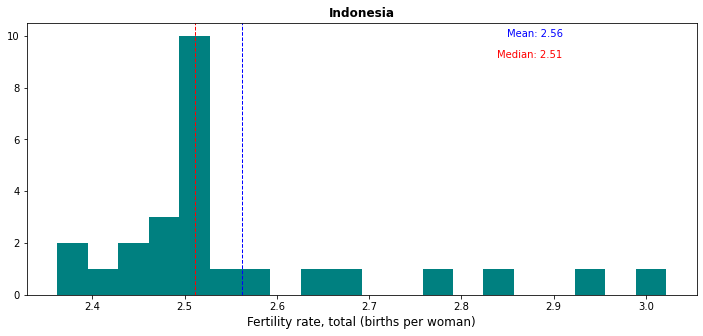

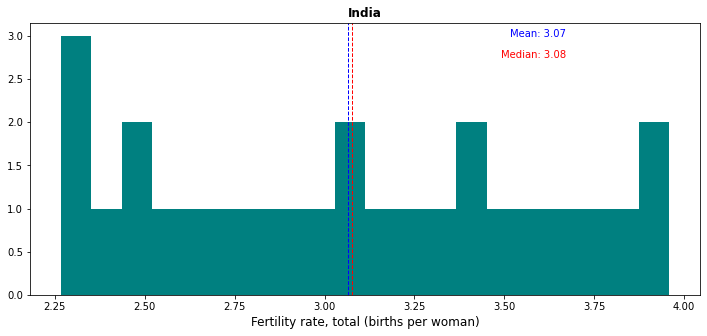

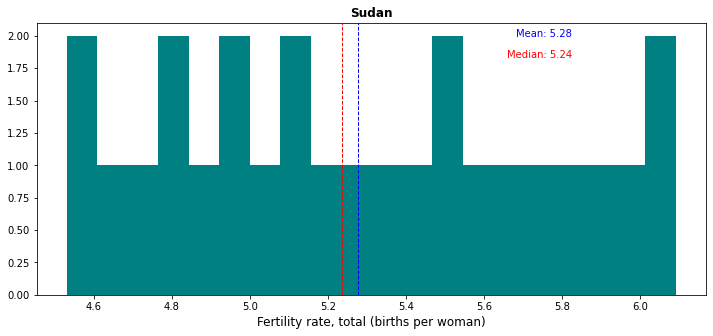

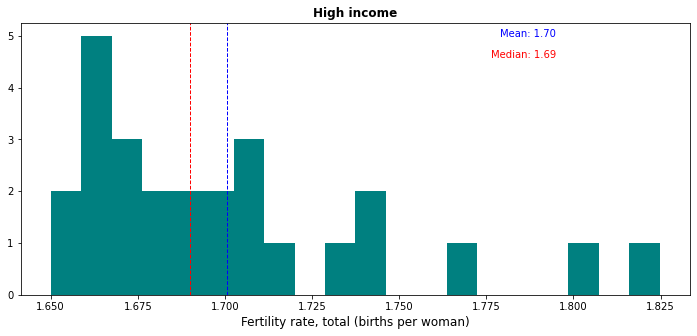

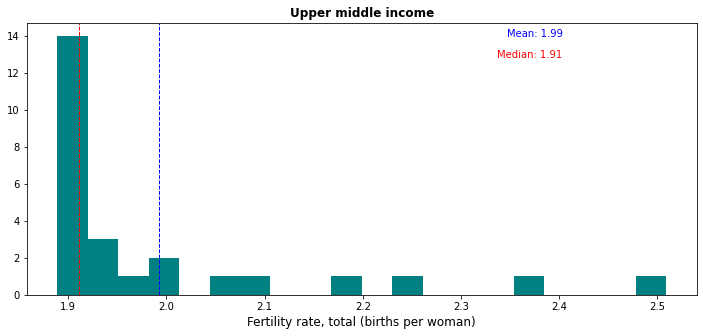

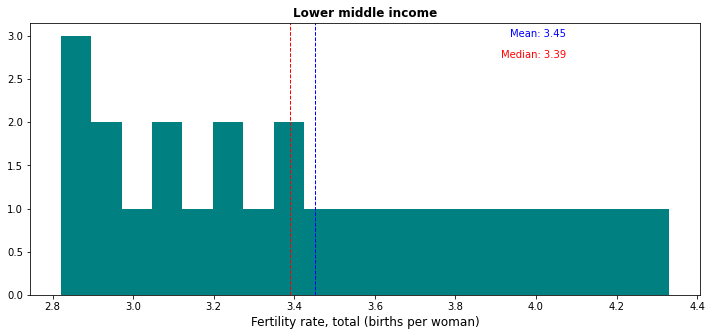

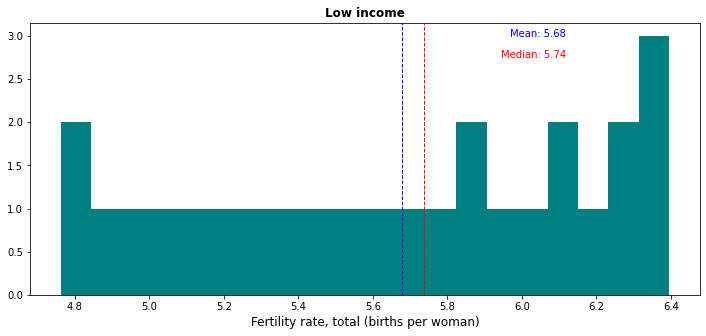

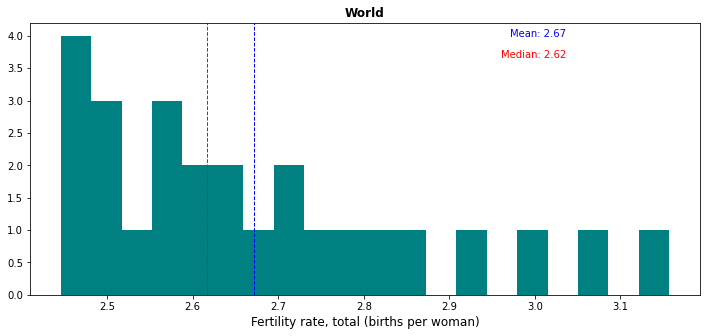

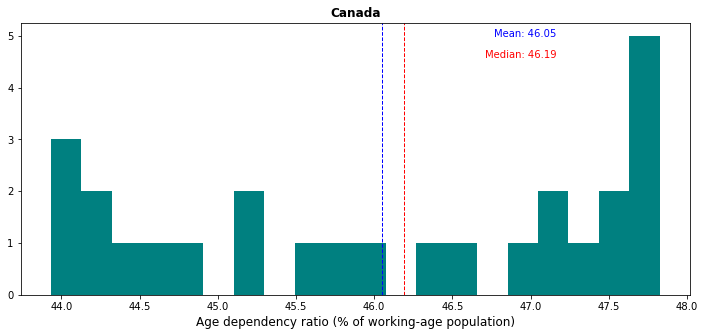

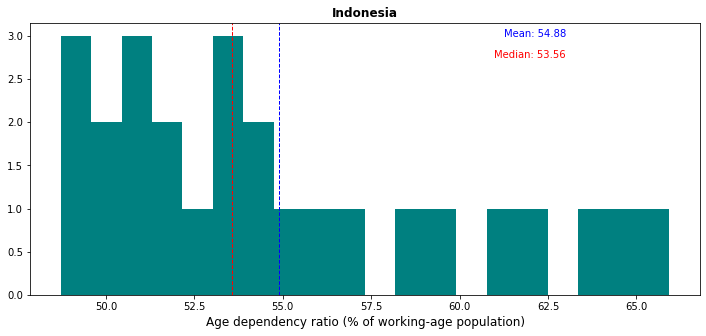

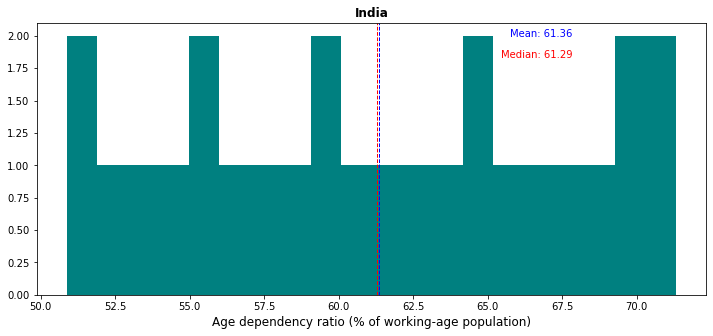

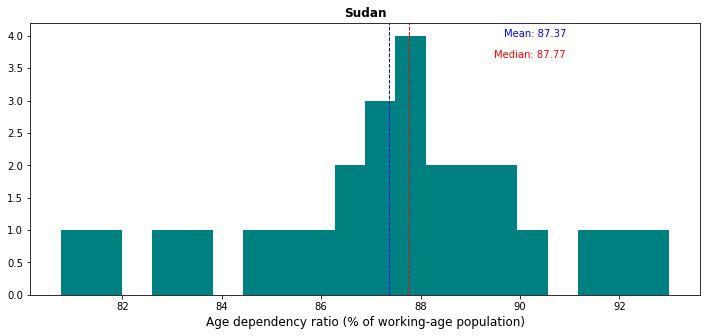

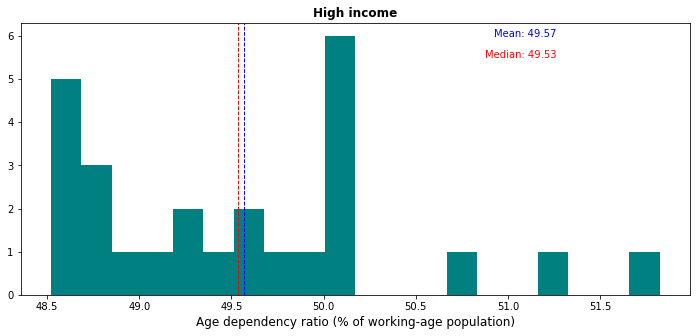

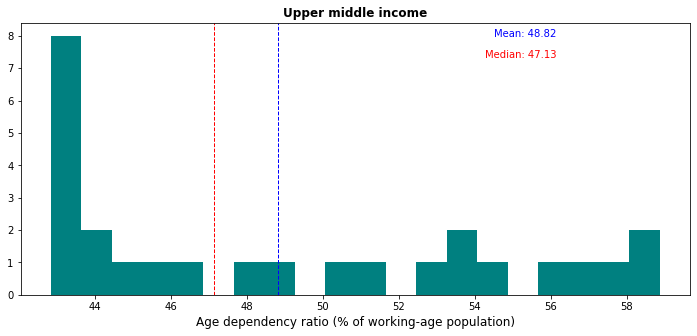

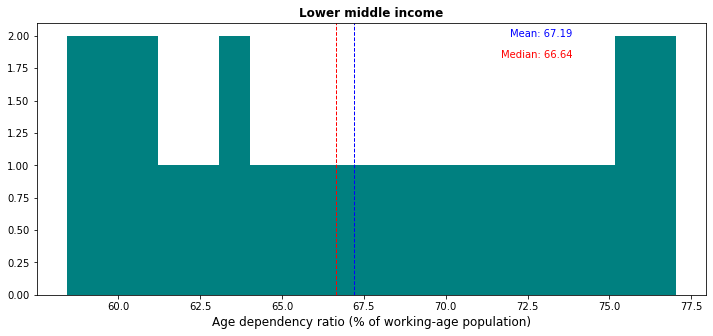

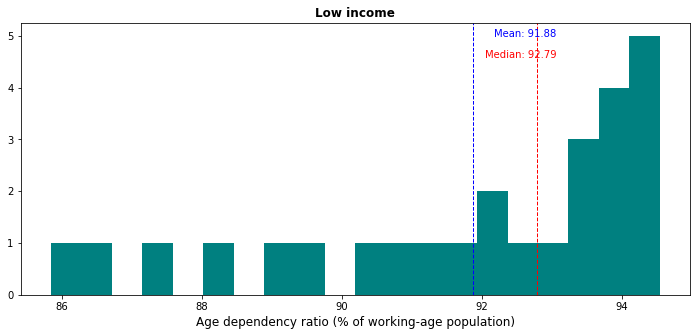

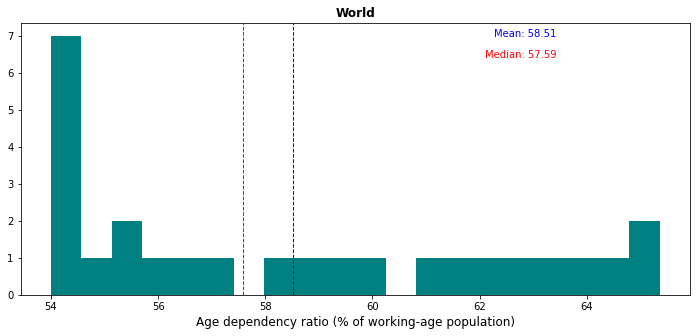

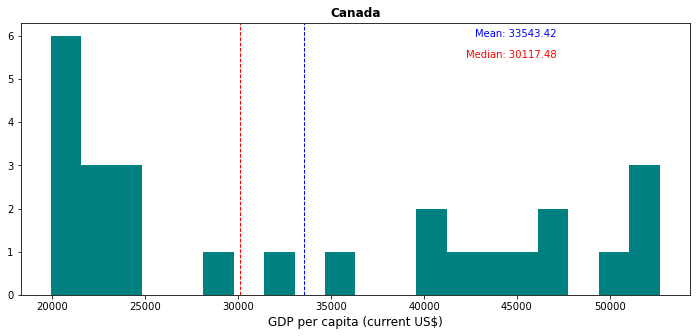

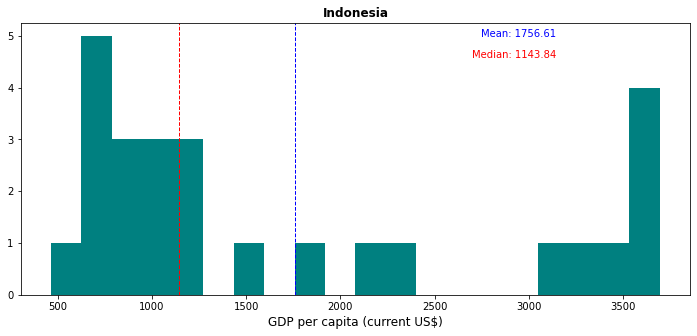

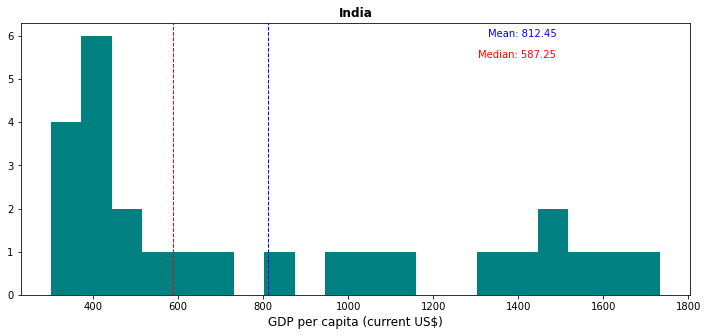

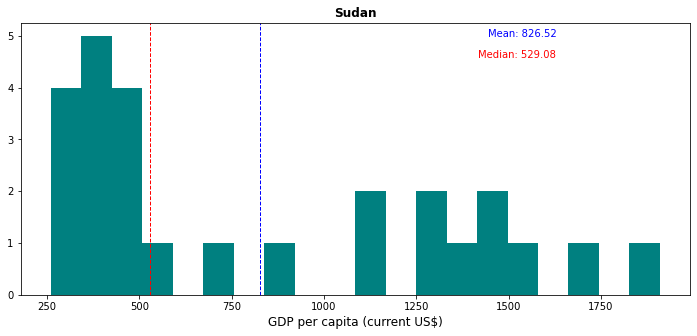

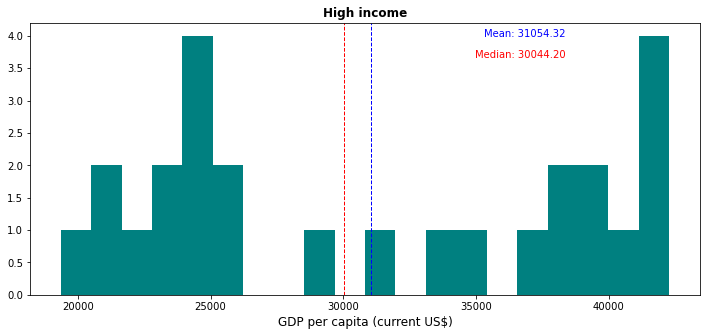

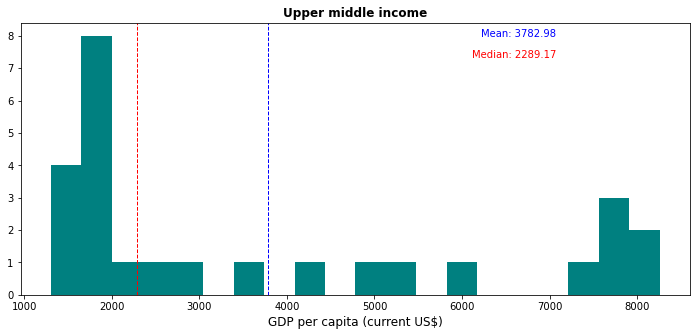

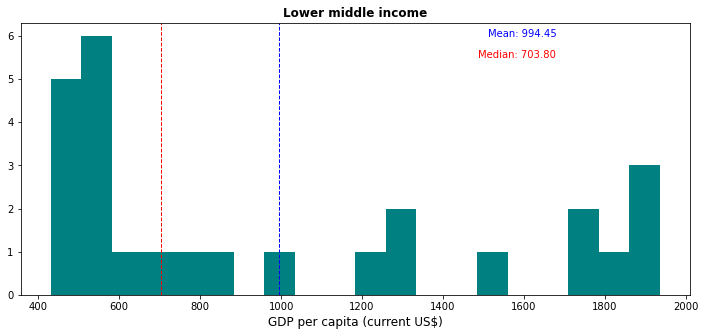

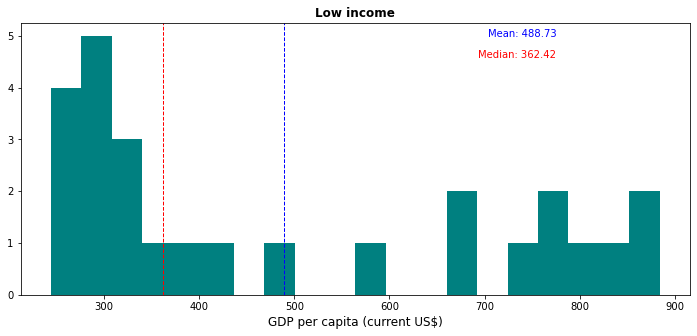

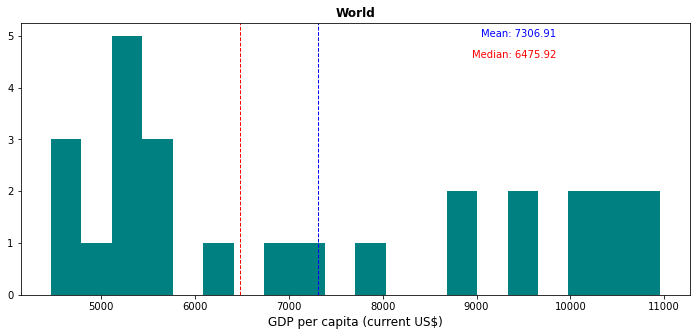

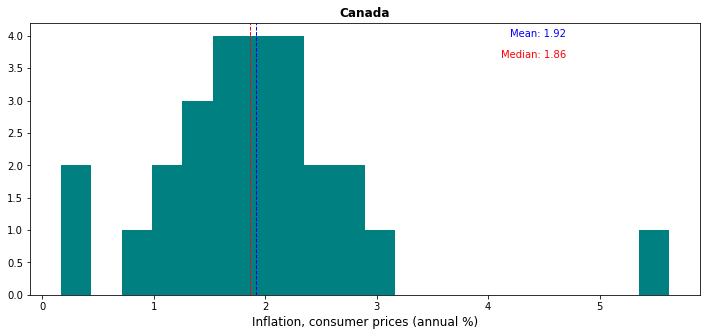

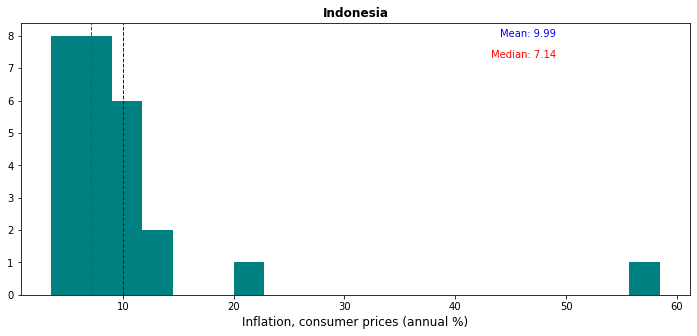

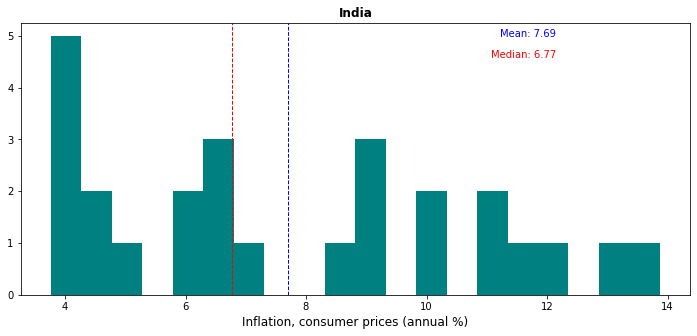

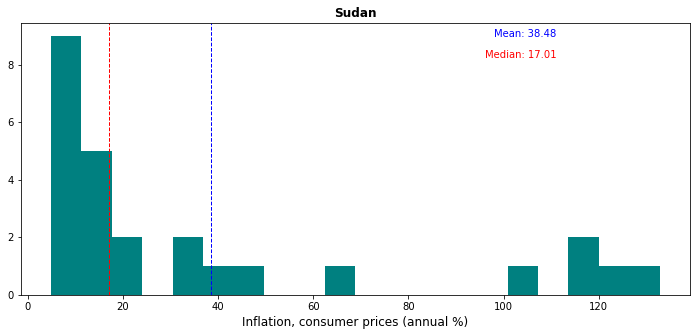

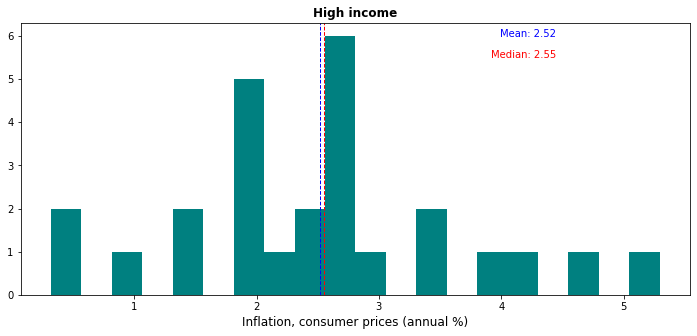

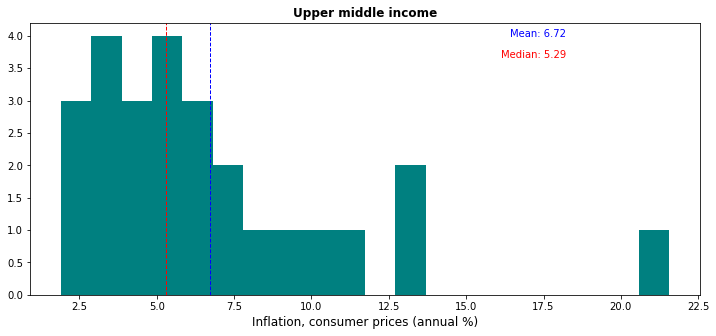

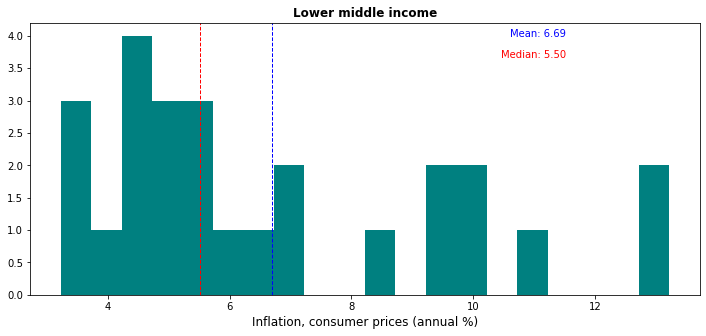

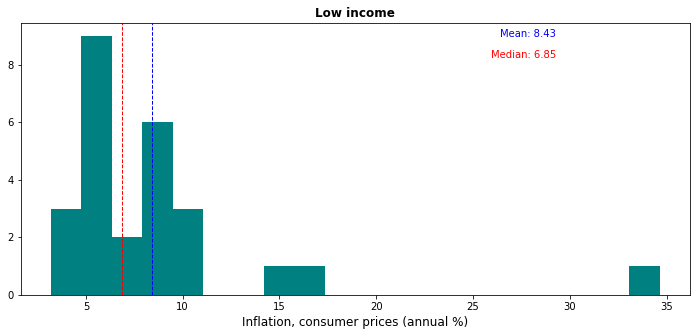

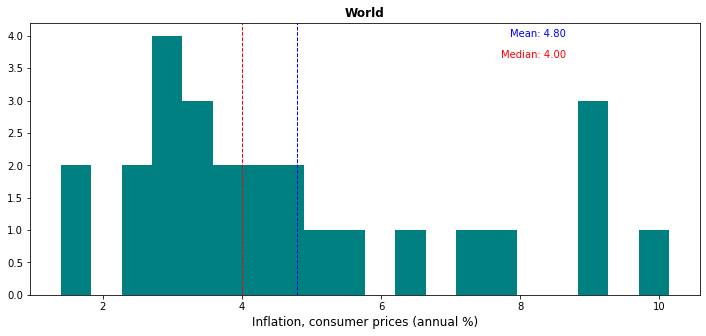

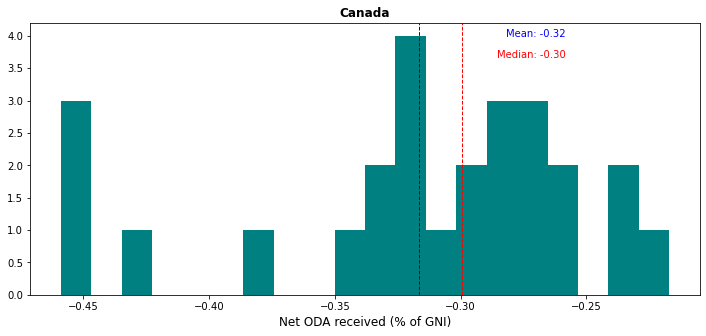

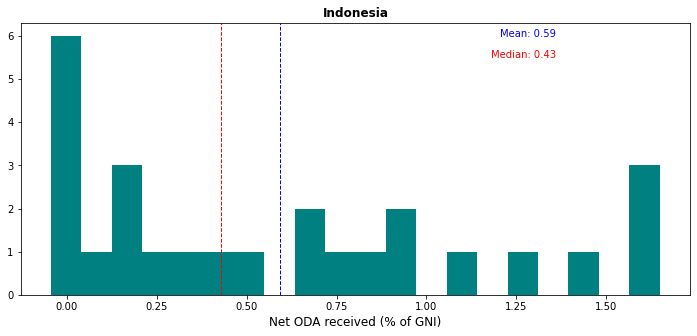

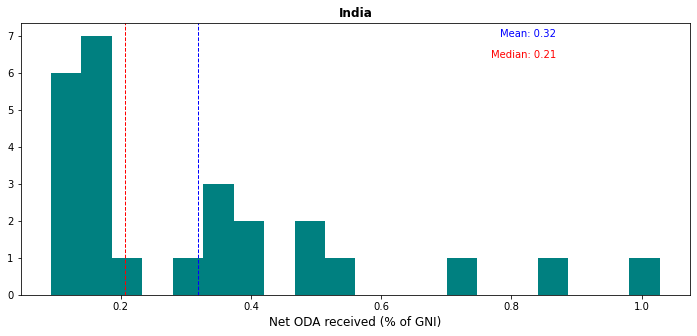

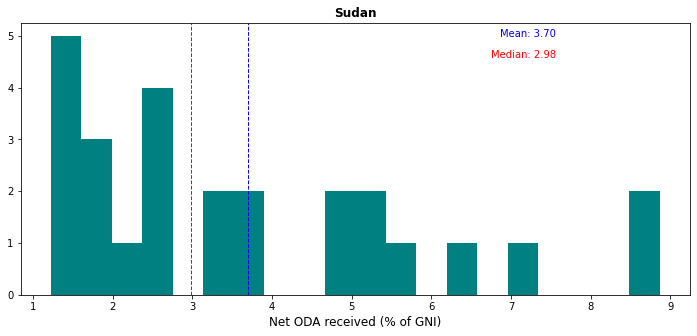

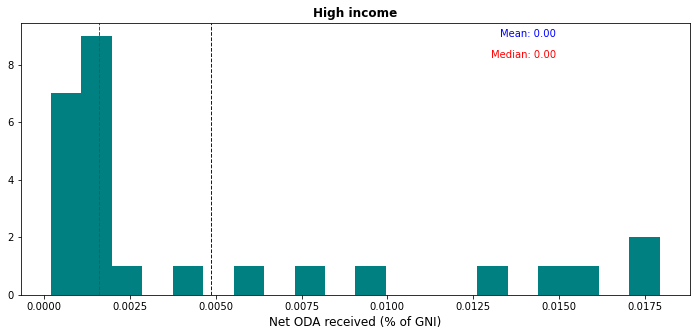

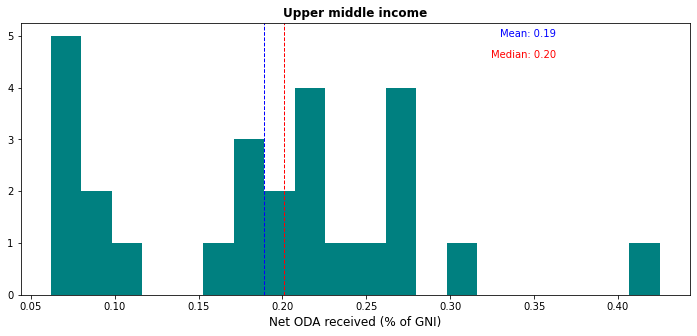

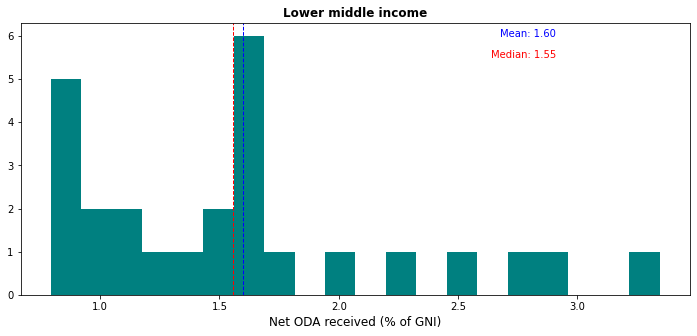

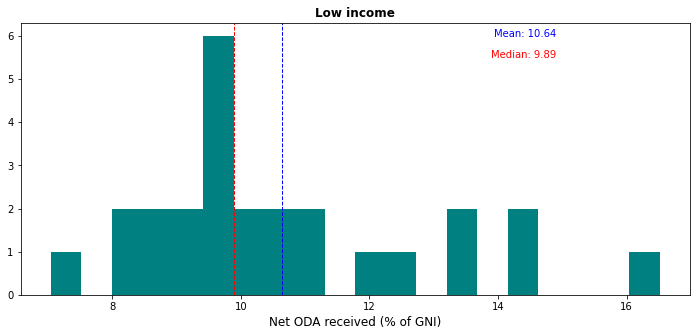

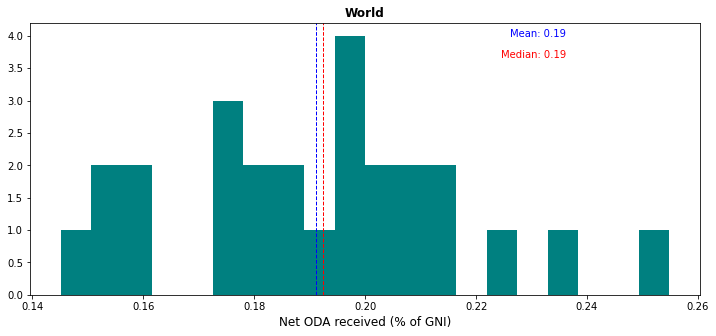

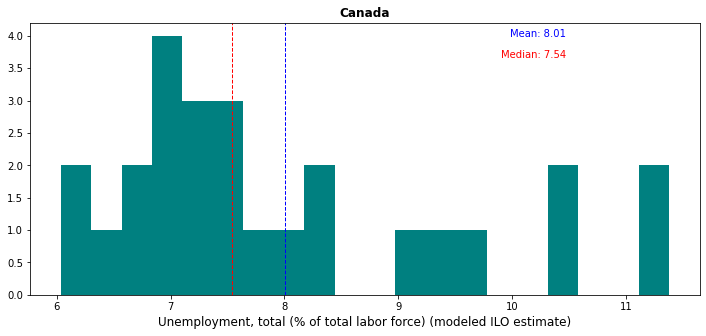

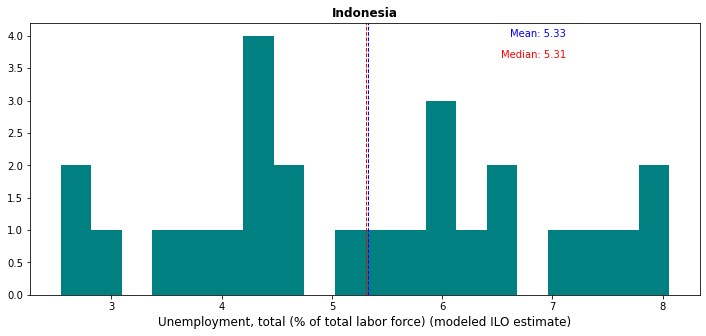

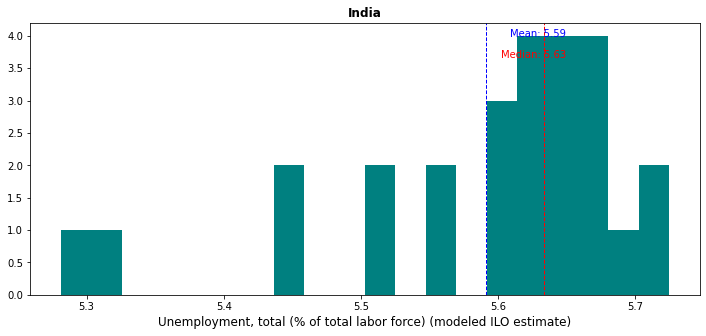

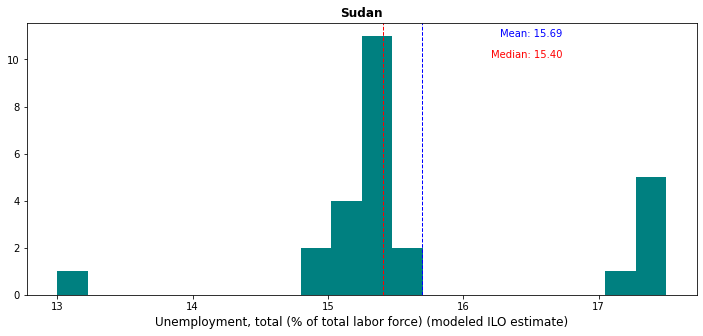

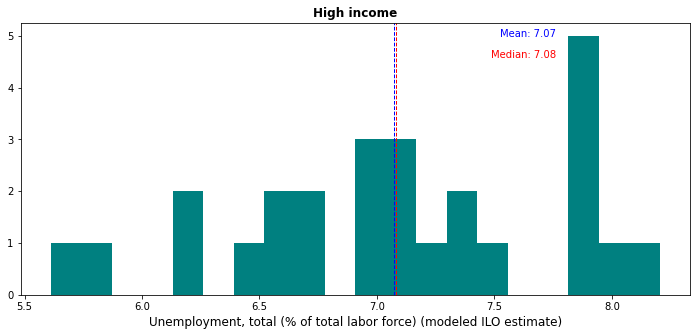

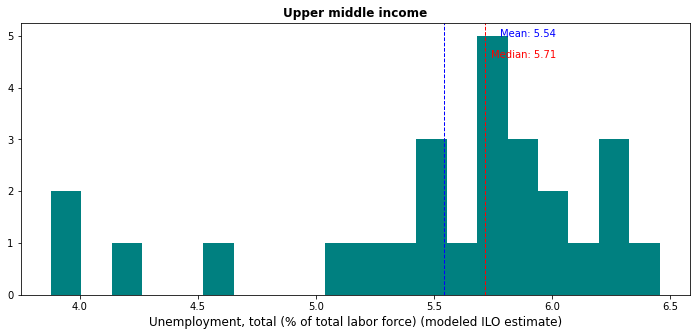

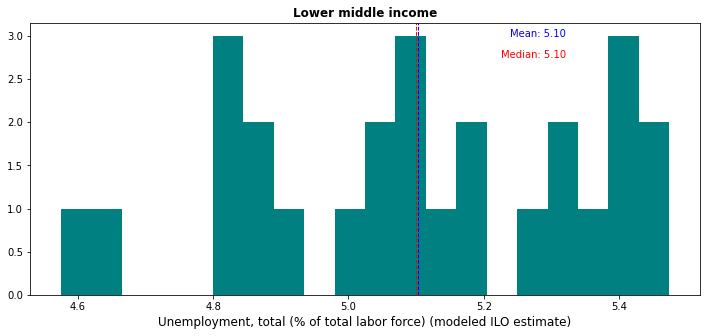

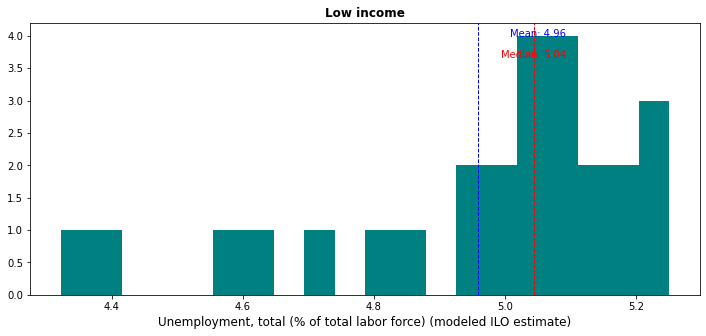

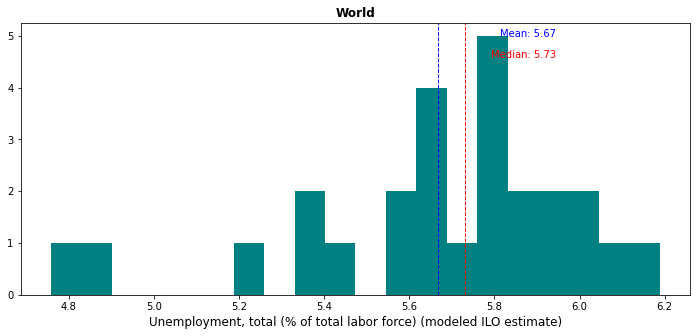

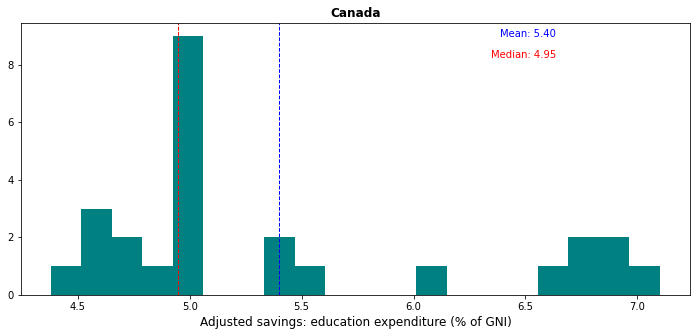

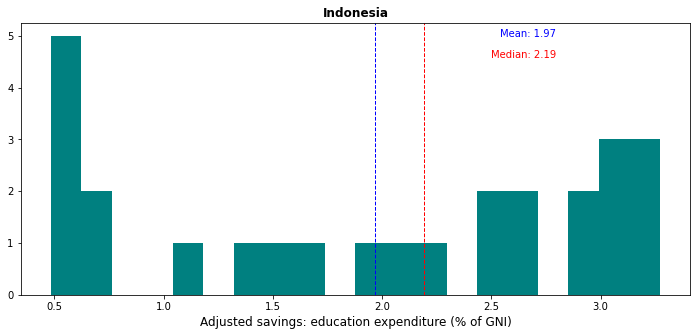

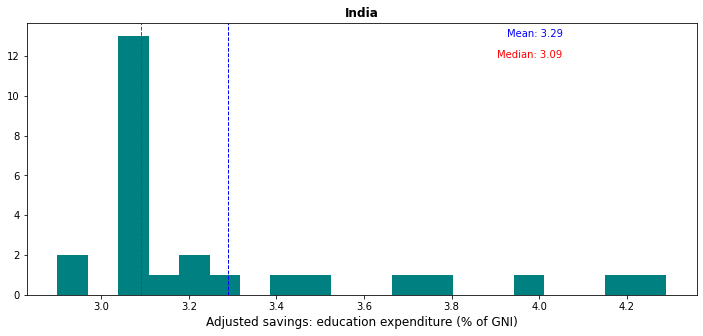

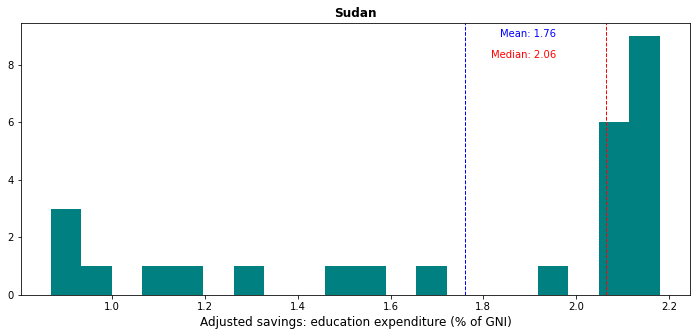

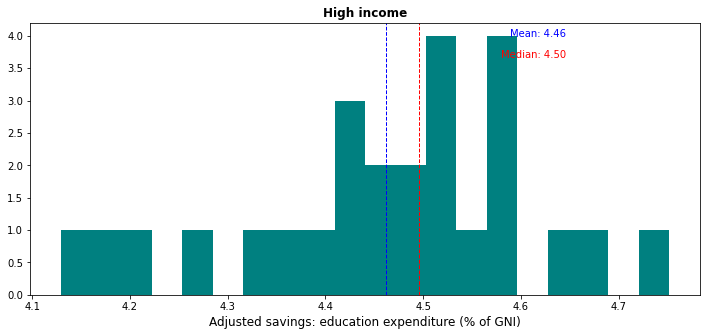

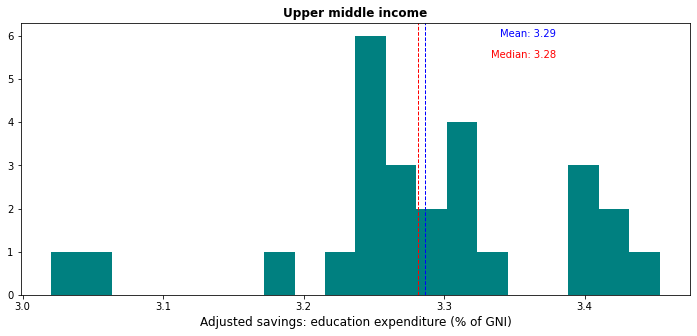

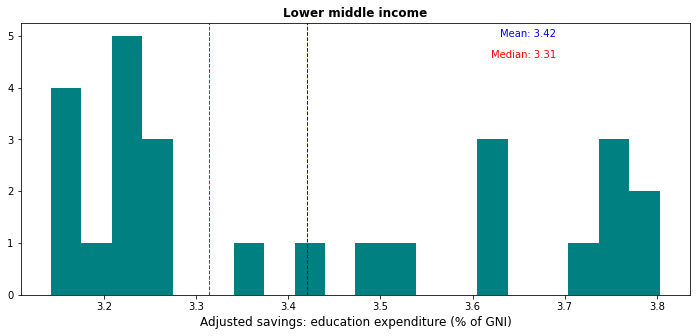

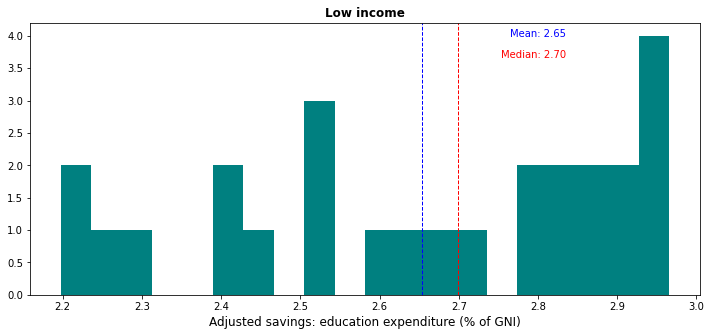

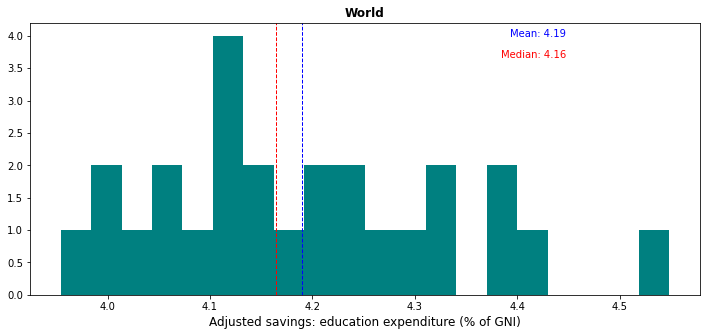

In [22]:
for i in range(0,len(variables)):
    for j in range(0,len(countries)):
        df=data_filtered[data_filtered['Country']==countries[j]]
        variable_name = variables[i]
        xlabel_value = label_names[i]
        plt.figure(figsize=(12, 5))
        plt.hist(data=df,x=variable_name,bins=20,color='teal')
        plt.xlabel(xlabel_value,fontsize=12);
        min_ylim, max_ylim = plt.ylim()
        ax = plt.gca()
        plt.axvline(df[variable_name].mean(), color='blue', linestyle='dashed', linewidth=1)
        plt.text(0.80,0.98, 'Mean: {:.2f}'.format(df[variable_name].mean()), horizontalalignment='right',verticalalignment='top',transform=ax.transAxes,color='blue')
        plt.axvline(df[variable_name].median(), color='red', linestyle='dashed', linewidth=1)
        plt.text(0.80,0.9, 'Median: {:.2f}'.format(df[variable_name].median()), horizontalalignment='right',verticalalignment='top',transform=ax.transAxes,color='red')
        plt.title(df['Country'].unique()[0],fontsize=12,weight='bold')
        plt.savefig(str(variable_name) + '_' + str(df['Country'].unique()[0]) + '.jpg')

Next, we also plot a time series line plot in order to see the trend of indices with respect to time.

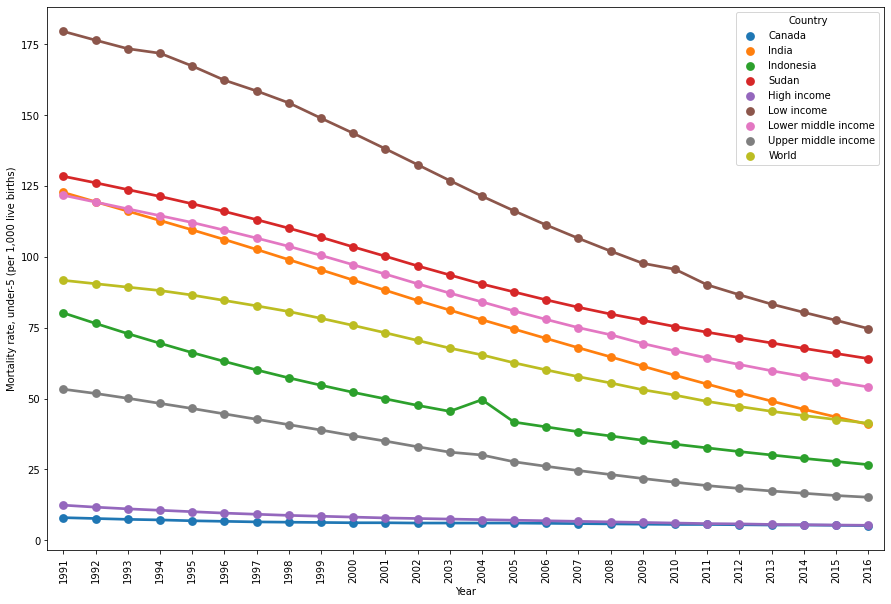

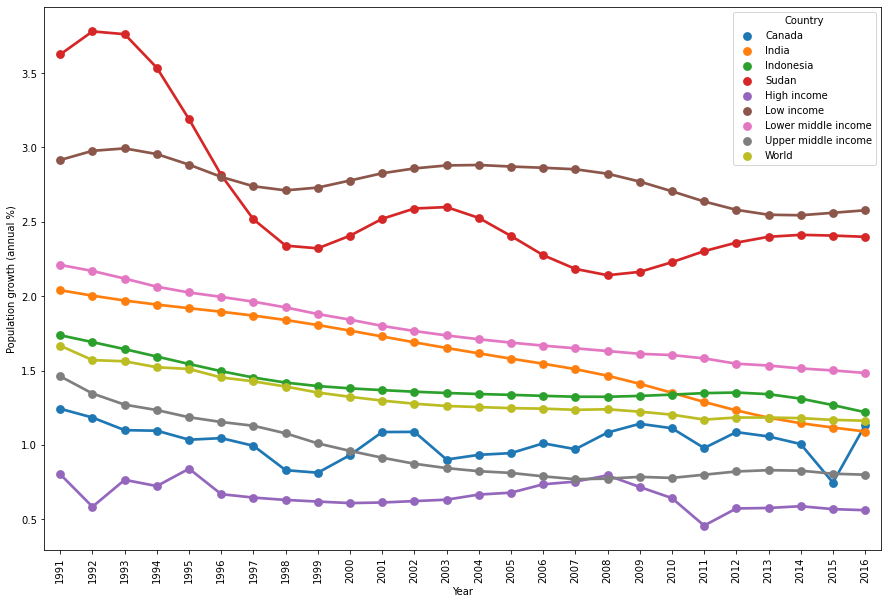

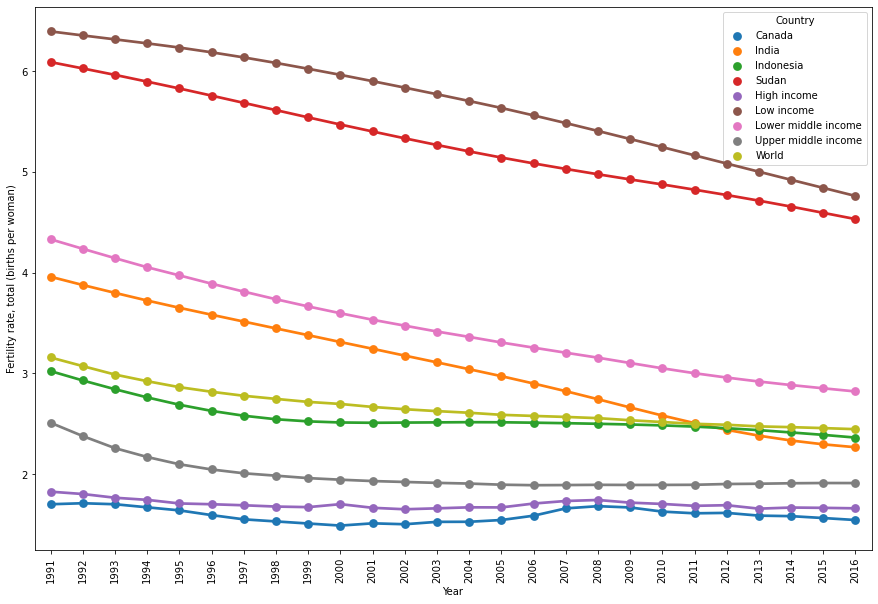

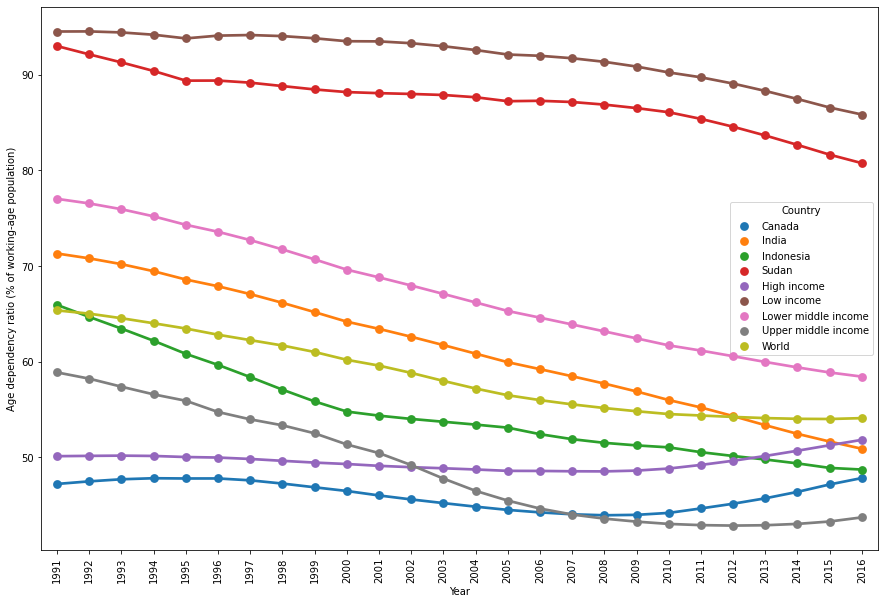

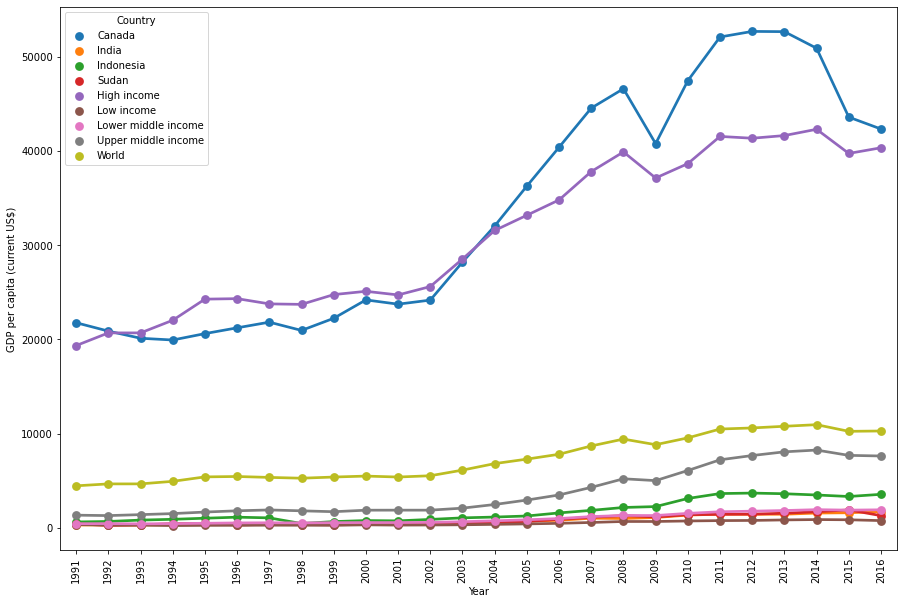

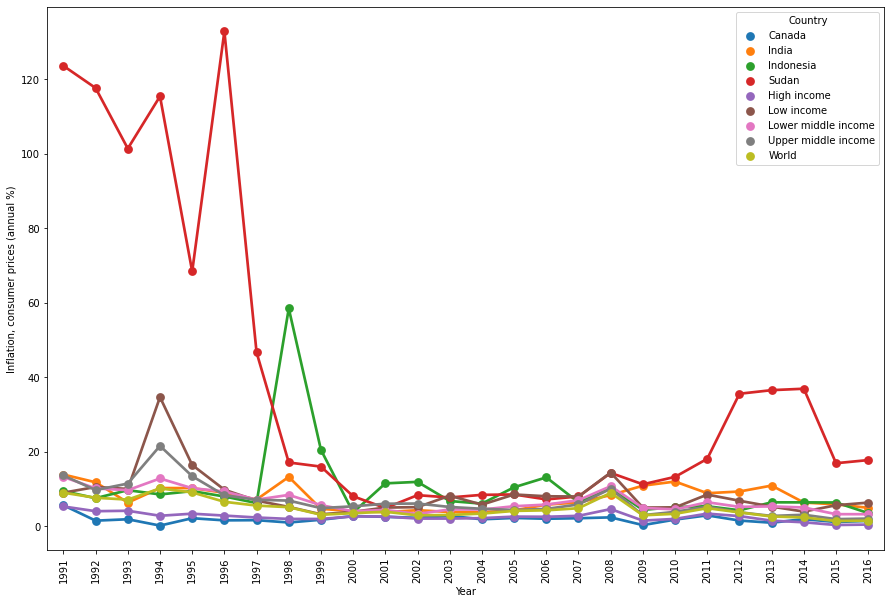

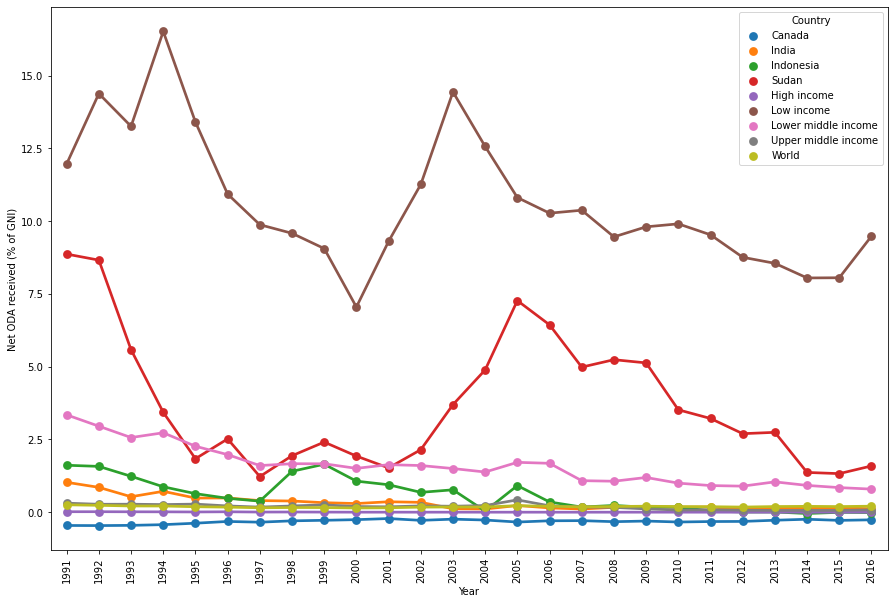

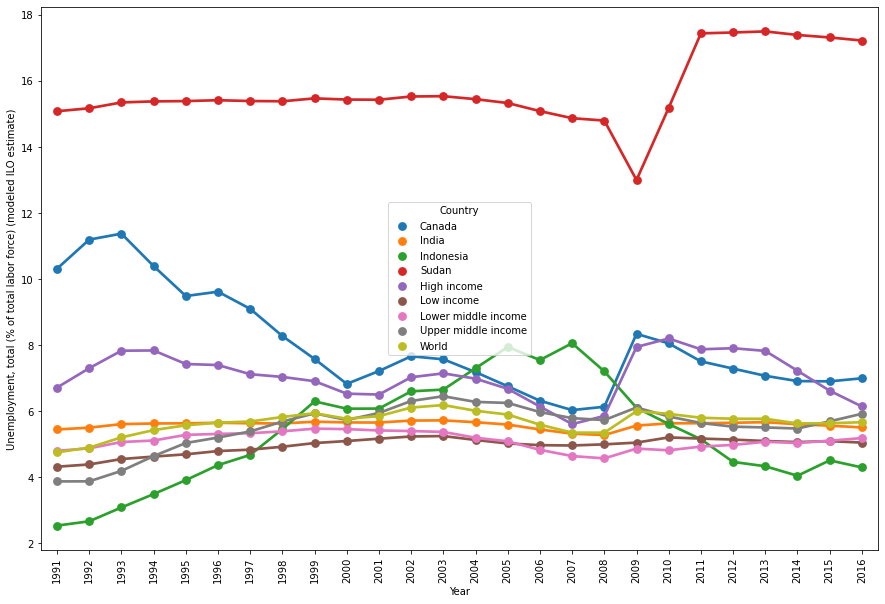

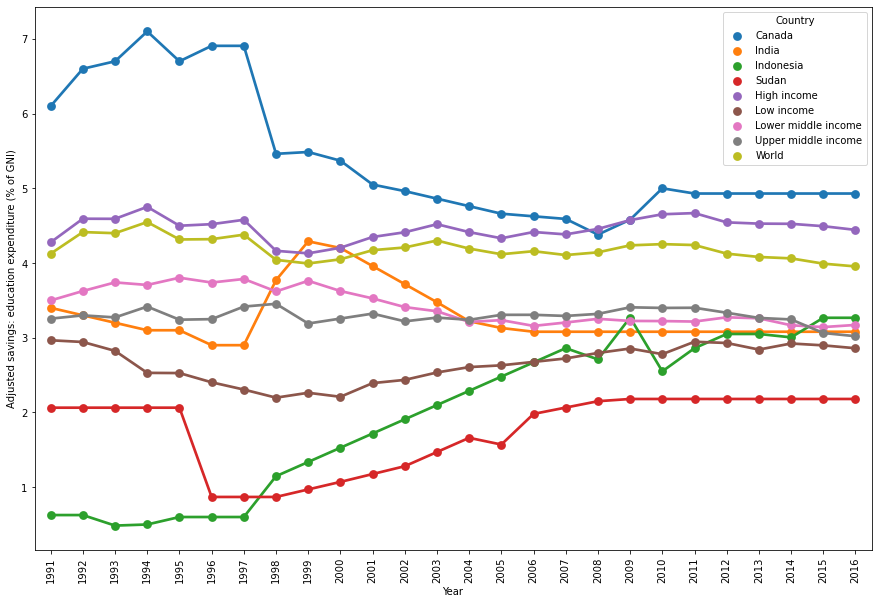

In [23]:
for i in range(0,len(variables)):
    plt.figure(figsize=(15,10))
    sns.pointplot(x='Year',y=variables[i],data =data_filtered[data_filtered['Country'].isin(countries)],hue='Country')
    plt.ylabel(label_names[i])
    plt.xticks(rotation=90);
    plt.savefig(str(variables[i]) + '_pointplot.jpg')

<a id='data_preprocessing'></a>
## Data Pre-processing
[Back to table of contents](#contents)

Before we proceed with regression, we must process our data to obtain better results

We will first drop the data for country groups such as the World average values, Arab World, Sub saharan country averages and so on. These represent the average value of all countries in that region. Since we are considering individual country data, we do not need the corresponding averages calculated by World bank

In [24]:
country_list = list(data_filtered['Country'].unique())
country_list = country_list[0:country_list.index('Zimbabwe')+1]
data_filtered = data_filtered[data_filtered['Country'].isin(country_list)]

Next, we will log transform the **Mortality rate** and the **GDP** variables for two reasons. One, the log of the variables will better represent them as log(GDP) and log(Mortality) would then be in 100's of the actual GDP and mortality. This is particularly useful because the rest of our independent variables represent percentages and smaller values in magnitude overall. Secondly, we want to capture how multiplicative (percentage) changes in GDP affecting the model. This is achieved by taking the log of GDP.

In [25]:
data_filtered['Mortality_log'] = np.log(data_filtered['Mortality'])
data_filtered['GDP_log'] = np.log(data_filtered['GDP'])

Next, we will plot the data to have a look at the relationship of every variable with each other. This will give us a good idea of any preprocessing that we must do before we run our regression model. We plot the data using seaborn's pairplot function that is shown below

<Figure size 1080x1080 with 0 Axes>

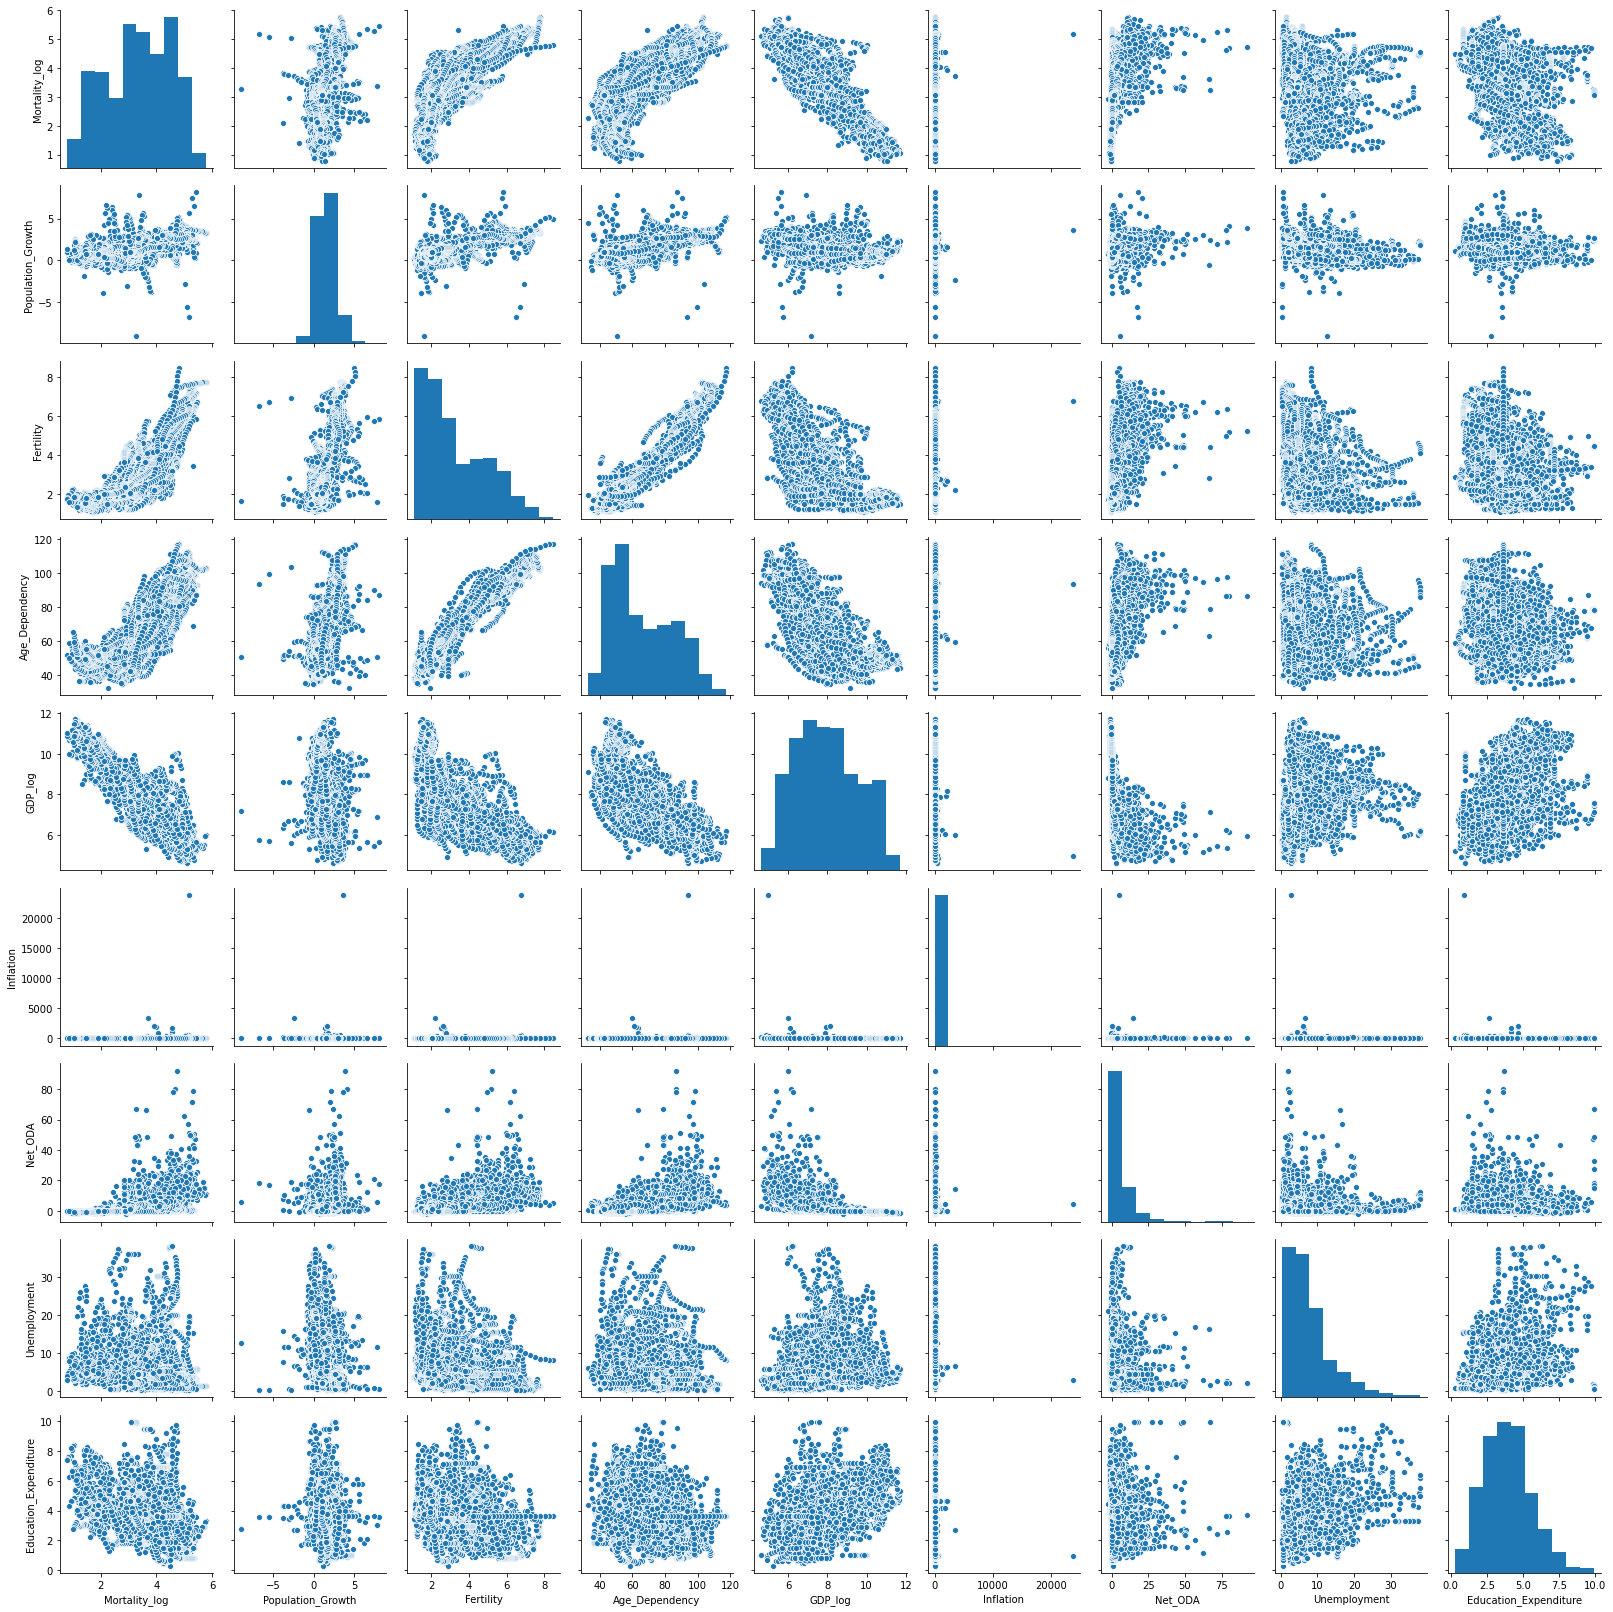

In [26]:
plt.figure(figsize=(15,15))
sns.pairplot(data_filtered[['Mortality_log', 'Population_Growth', 'Fertility',
       'Age_Dependency', 'GDP_log', 'Inflation', 'Net_ODA', 'Unemployment',
       'Education_Expenditure']]);
plt.tight_layout()
plt.savefig('Pairplot_before.jpg');

From the data, we can see that there are some issues that we need to take care of. 

1) The **Inflation** index has some outliers in the data that might be bad for the regression algorithm

We can take care of this issue by excluding the outliers from our dataset for regression. After inspection, we can see there are some values of inflation that are above 200 and below -10 that might have been recorded due to false entries or some special situations that might have caused such values to occur. We will exclude these samples from our dataset.

In [27]:
data_filtered = data_filtered[data_filtered['Inflation']<200]
data_filtered = data_filtered[data_filtered['Inflation']>-10]

2) **Population Growth** seems to have outliers too. 

We can take care of this issue as well by excluding the outliers from our dataset. We have some samples where the reported population growth is less than -2% and some samples have population growth above 6% which are not representative of the overall data. We will exclude these samples from our dataset as well.

In [28]:
data_filtered = data_filtered[data_filtered['Population_Growth']>-2]
data_filtered = data_filtered[data_filtered['Population_Growth']<6]

3) **Net_ODA** seems to have outliers too. 

We can take care of this issue as well by excluding the outliers from our dataset. We have some samples where the reported Net ODA is above 50% which are not representative of the overall data. We will exclude these samples from our dataset as well.

In [29]:
data_filtered = data_filtered[data_filtered['Net_ODA']<50]

A very important point to be noted here is that the data that has been dropped above does not include any samples from the 4 countries of interest. We have dropped the data that do not represent the usual trend in the indices due to probable error in recording the information or natural situations such as famine, war or national emergencies that might have caused the outliers. We drop such information because our goal is to analyse the 4 countries we have chosen and to make comments on them. Data from other countries are used to make the linear regression model more robust and have a better overall fit.

4) **Fertility** and **Age_Dependency** seem to have a very high correlation amongst themselves. Correlation between independent variables is called multicollinearity and this causes issues in the regression algorithm too.

One way to analyze multicollinearity is using the [**Variance inflation factor (VIF)**](https://www.statisticshowto.com/variance-inflation-factor/). Values greater than 5 indicate the presence of high multicollinearity in our data. Let us calculate the VIF as shown below


In [30]:
# get y and X dataframes based on this regression:
y_vif, X_vif = dmatrices('Mortality_log ~ Population_Growth + Fertility + Age_Dependency + GDP_log + Inflation + Net_ODA + Unemployment + Education_Expenditure' , data_filtered, return_type='dataframe')

# For each X, calculate VIF and save in dataframe
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(X_vif.values, i) for i in range(X_vif.shape[1])]
vif["features"] = X_vif.columns
vif

VIF Factor               features
0  158.199010              Intercept
1    2.998974      Population_Growth
2   15.781789              Fertility
3   11.305324         Age_Dependency
4    2.922615                GDP_log
5    1.104176              Inflation
6    1.864246                Net_ODA
7    1.150981           Unemployment
8    1.326437  Education_Expenditure

Note: The **"Intercept"** value shown here is just the constant intercept value (alpha) that gets added in a linear regression model. We do not need to consider the VIF for the intercept.

This shows us that **Fertility** and **Age_Dependency** are highly correlated. One way to deal with this issue is to eliminate one of the variable. The other better way is to combine the 2 indices into a single variable that represents both indices. We do this by considering a new variable called **Fertility_Age_Dependency_log** that considers the log of the product of the 2 variables as shown below

In [31]:
data_filtered['Fertility_Age_Dependency_log'] = np.log(data_filtered['Fertility'] * data_filtered['Age_Dependency'])

Now let us run the VIF check once again and also plot our new data to visualize the scatterplots again

In [32]:
# get y and X dataframes based on this regression:
y_vif, X_vif = dmatrices('Mortality_log ~ Population_Growth + Fertility_Age_Dependency_log + GDP_log + Inflation + Net_ODA + Unemployment + Education_Expenditure' , data_filtered, return_type='dataframe')

# For each X, calculate VIF and save in dataframe
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(X_vif.values, i) for i in range(X_vif.shape[1])]
vif["features"] = X_vif.columns
vif

VIF Factor                      features
0  409.984492                     Intercept
1    2.932390             Population_Growth
2    5.330130  Fertility_Age_Dependency_log
3    3.170646                       GDP_log
4    1.104163                     Inflation
5    1.798362                       Net_ODA
6    1.138263                  Unemployment
7    1.316220         Education_Expenditure

<Figure size 1080x1080 with 0 Axes>

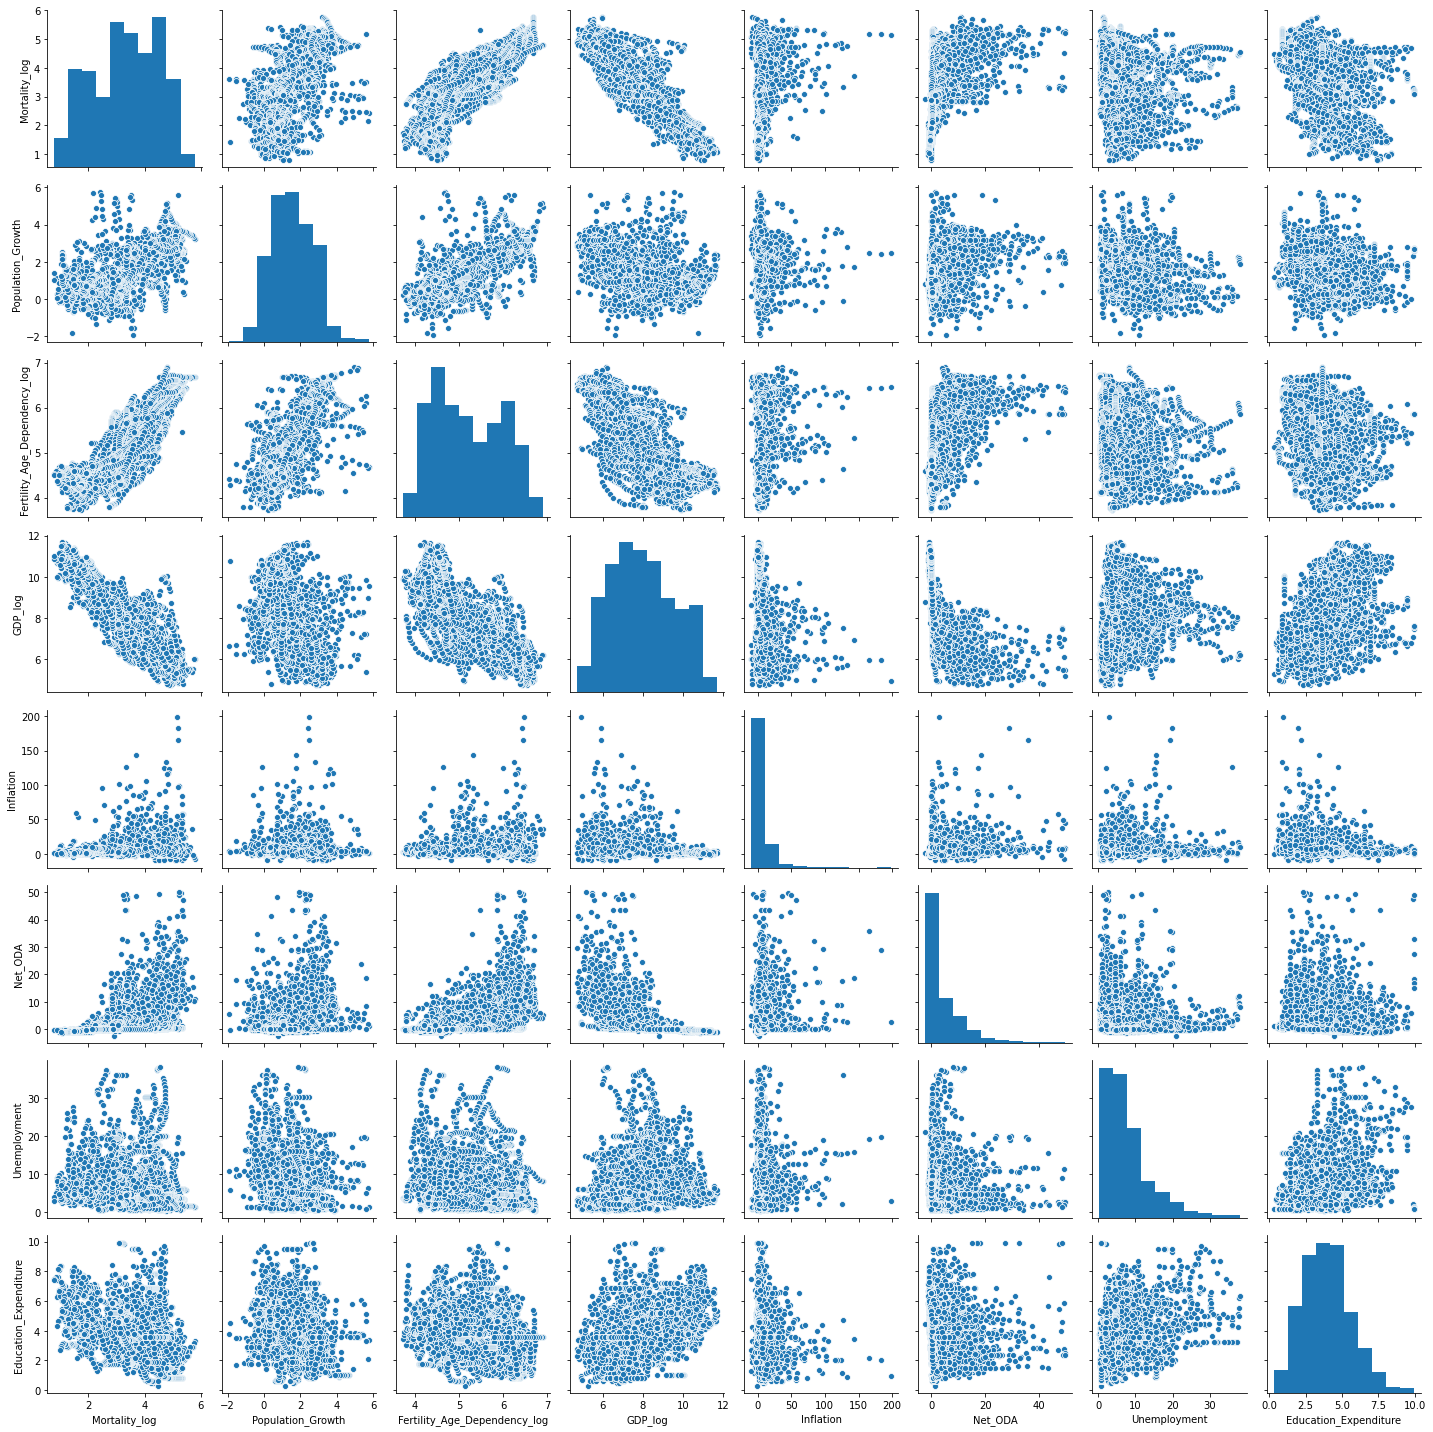

In [33]:
plt.figure(figsize=(15,15))
sns.pairplot(data_filtered[['Mortality_log', 'Population_Growth', 'Fertility_Age_Dependency_log', 'GDP_log', 'Inflation', 'Net_ODA', 'Unemployment',
       'Education_Expenditure']]);
plt.tight_layout()
plt.savefig('Pairplot_after.jpg')

Now that we have performed the preprocessing on our data, we will declare dummy variables for the 4 income groups. We will include these variables in our regression model. 

In [34]:
dummy = pd.get_dummies(data_filtered['IncomeGroup'])

In [35]:
data_filtered['High_Income_Dummy'] = dummy['High income']
data_filtered['Upper_Middle_Income_Dummy'] = dummy['Upper middle income']
data_filtered['Lower_Middle_Income_Dummy'] = dummy['Low income']

In [36]:
data_filtered.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3340 entries, 49 to 13232
Data columns (total 18 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Year                          3340 non-null   int64  
 1   Country                       3340 non-null   object 
 2   IncomeGroup                   3340 non-null   object 
 3   Mortality                     3340 non-null   float64
 4   Population_Growth             3340 non-null   float64
 5   Fertility                     3340 non-null   float64
 6   Age_Dependency                3340 non-null   float64
 7   GDP                           3340 non-null   float64
 8   Inflation                     3340 non-null   float64
 9   Net_ODA                       3340 non-null   float64
 10  Unemployment                  3340 non-null   float64
 11  Education_Expenditure         3340 non-null   float64
 12  Mortality_log                 3340 non-null   float64
 13  G

In [37]:
data_filtered.describe()

Year    Mortality  Population_Growth    Fertility  \
count  3340.000000  3340.000000        3340.000000  3340.000000   
mean   2004.193114    49.510808           1.541471     3.257187   
std       7.330115    49.684262           1.131867     1.646411   
min    1991.000000     2.200000          -1.944629     1.076000   
25%    1998.000000    10.775000           0.634170     1.860000   
50%    2005.000000    29.200000           1.440223     2.751500   
75%    2010.000000    76.625000           2.457399     4.527250   
max    2016.000000   322.200000           5.756702     8.459000   

       Age_Dependency            GDP    Inflation      Net_ODA  Unemployment  \
count     3340.000000    3340.000000  3340.000000  3340.000000   3340.000000   
mean        66.237652    9543.631066     7.874470     4.461583      7.949543   
std         18.784892   15731.681027    13.328014     7.070891      6.290625   
min         32.634060     111.927224    -9.616154    -2.312579      0.317000   
25%         50.237572     846.914146     2.095033     0.030399      3.563500   
50%         61.444815    2761.487336     4.470025     1.322127      6.179000   
75%         81.750057    9987.132731     8.644508     6.540124     10.345750   
max        117.467702  118823.648369   198.516707    49.912275     37.976002   

       Education_Expenditure  Mortality_log      GDP_log  \
count            3340.000000    3340.000000  3340.000000   
mean                3.963765       3.326803     8.002794   
std                 1.674692       1.164605     1.584628   
min                 0.300000       0.788457     4.717849   
25%                 2.760000       2.377221     6.741599   
50%                 3.853770       3.374169     7.923525   
75%                 4.980370       4.338923     9.209051   
max                 9.940000       5.775172    11.685396   

       Fertility_Age_Dependency_log  High_Income_Dummy  \
count                   3340.000000        3340.000000   
mean                       5.208913           0.282036   
std                        0.771598           0.450058   
min                        3.718556           0.000000   
25%                        4.538013           0.000000   
50%                        5.108762           0.000000   
75%                        5.915897           1.000000   
max                        6.901394           1.000000   

       Upper_Middle_Income_Dummy  Lower_Middle_Income_Dummy  
count                3340.000000                3340.000000  
mean                    0.268563                   0.146707  
std                     0.443278                   0.353866  
min                     0.000000                   0.000000  
25%                     0.000000                   0.000000  
50%                     0.000000                   0.000000  
75%                     1.000000                   0.000000  
max                     1.000000                   1.000000

We will save this in a separate excel for future references. The final output data is stored in the file **Final_Data.xlsx**

In [38]:
data_filtered.to_excel("Final_Data.xlsx")

<a id='normality_check'></a>
## Normality Check of the dependent variable
[Back to table of contents](#contents)

In order to test the normality of the dependent variable, we use the **Shapiro Wilk** hypothesis test. The Null and Alternate hypothesis are mentioned below

H<sub>0</sub>: The empirical distribution follows the normal distribution<br>
H<sub>A</sub>: The empirical distribution is non normal



In [40]:
shapiro_wilk_test = shapiro(data_filtered['Mortality_log'])
shapiro_wilk_test

ShapiroResult(statistic=0.9643254280090332, pvalue=5.606654587198374e-28)

Based on the normality test of the dependent variable, it can be seen that the **Shapiro Wilk** test has **rejected the Null hypothesis that the Mortality(log) rate is normal in nature**. Also, one important point to be noted is the normality of the dependent variable is calculated for all the countries (ie all samples included) because we will be using all samples in our regression algorithm.

The dependent variable is non-normal, however, the important measure is if our residuals obtained after regression analysis are normal. We will verify this once we run our regression algorithm.

<a id='data_comparison'></a>
## Data Comparison across countries
[Back to table of contents](#contents)



Before we run the regression analysis, our goal is to first try to analyze the **Mortality** across our 4 countries under consideration. We can use a related samples t-test to compare the means. However, in order to do that, we need to first check if the Mortality is normal in all 4 countries. Else we will have to make use of other non-parametric procedures. 

We do this with the help of the same **Shapiro Wilk** test that was shown above.

In [41]:
shapiro_wilk_results = {}
#Countries under consideration
countries = ['Canada','Indonesia','India','Sudan']
for country in countries:
    shapiro_wilk_test = shapiro(data_filtered[data_filtered['Country']==country].loc[:, "Mortality"])
    shapiro_wilk_results[country] = shapiro_wilk_test
shapiro_wilk_results

{'Canada': ShapiroResult(statistic=0.9247317910194397, pvalue=0.058108843863010406),
 'Indonesia': ShapiroResult(statistic=0.9379182457923889, pvalue=0.11976897716522217),
 'India': ShapiroResult(statistic=0.9517221450805664, pvalue=0.2543748915195465),
 'Sudan': ShapiroResult(statistic=0.9350665807723999, pvalue=0.10236745327711105)}

In [42]:
shapiro_wilk_results = {}
#Countries under consideration
countries = ['Canada','Indonesia','India','Sudan']
for country in countries:
    shapiro_wilk_test = shapiro(data_filtered[data_filtered['Country']==country].loc[:, "Mortality_log"])
    shapiro_wilk_results[country] = shapiro_wilk_test
shapiro_wilk_results

{'Canada': ShapiroResult(statistic=0.9478151202201843, pvalue=0.20603375136852264),
 'Indonesia': ShapiroResult(statistic=0.9558691382408142, pvalue=0.3167773485183716),
 'India': ShapiroResult(statistic=0.947063684463501, pvalue=0.1977851241827011),
 'Sudan': ShapiroResult(statistic=0.9398000836372375, pvalue=0.1328408420085907)}

The results of the Shapiro Wilk test for normality shows that the **Mortality** as well as the log transformed **Mortality_log** dependent variable is normal since we are not able to reject the Null hypothesis for either country.

Now we can proceed with the related samples t-test. 

*Note: The python library scipy does not have the provision to conduct a one tailed t-test. So we will perform a two tailed test with the following hypothesis*

H<sub>0</sub>: The means difference between two samples is 0<br>
H<sub>A</sub>: The means difference between two samples is not 0

If we reject the Null hypothesis, we say the mean difference between mortality is not same between 2 countries.

In [43]:
from scipy import stats

countries = ['Canada','Indonesia','India','Sudan']
country_A = []
country_B = []
comparisons = []
for i in range(0,len(countries)):
    for j in range(i+1,len(countries)):
        comparisons.append(stats.ttest_rel(data_filtered[data_filtered['Country']==countries[i]]['Mortality'],data_filtered[data_filtered['Country']==countries[j]]['Mortality']))
        country_A.append(countries[i])
        country_B.append(countries[j])
df_comparison = pd.DataFrame(list(zip(country_A, country_B,comparisons)),columns =['Country A', 'Country B','Related samples T Test for mean Mortality'])
df_comparison

Country A  Country B      Related samples T Test for mean Mortality
0     Canada  Indonesia   (-13.797446509364107, 3.410195530900706e-13)
1     Canada      India   (-15.240969320787876, 3.657068769055012e-14)
2     Canada      Sudan   (-22.273897715466724, 5.259651587229994e-18)
3  Indonesia      India   (-16.669819364453087, 4.722963752049622e-15)
4  Indonesia      Sudan   (-43.669316235569504, 3.984566904131311e-25)
5      India      Sudan  (-14.333349683806082, 1.4581012648610455e-13)

In [44]:
from scipy import stats

countries = ['Canada','Indonesia','India','Sudan']
country_A = []
country_B = []
comparisons = []
for i in range(0,len(countries)):
    for j in range(i+1,len(countries)):
        comparisons.append(stats.ttest_rel(data_filtered[data_filtered['Country']==countries[i]]['Mortality_log'],data_filtered[data_filtered['Country']==countries[j]]['Mortality_log']))
        country_A.append(countries[i])
        country_B.append(countries[j])
df_comparison = pd.DataFrame(list(zip(country_A, country_B,comparisons)),columns =['Country A', 'Country B','Related samples T Test for mean Mortality(log)'])
df_comparison

Country A  Country B Related samples T Test for mean Mortality(log)
0     Canada  Indonesia   (-44.73133121441488, 2.2012549227714085e-25)
1     Canada      India   (-55.22313280768847, 1.1944599405947308e-27)
2     Canada      Sudan  (-114.85038498956706, 1.4443368980830162e-35)
3  Indonesia      India    (-50.68629436585027, 9.999769732839258e-27)
4  Indonesia      Sudan    (-30.7023205551561, 2.2738208384434466e-21)
5      India      Sudan   (-8.098325830431387, 1.8792542752571738e-08)

From the above calculations, it is clear that the mean mortality for all 4 countries are different than each other.

Also, given the p and t values from a two-tailed test, we can say that we would reject the null hypothesis of a less-than one tailed t-test when p/2 < alpha and t < 0. Clearly that is the case with all comparisons above.

Therefore we can safely say, the mean mortality follows the order Canada < Indonesia < India < Sudan.

The mean value of Mortality and the corresponding 95% confidence intervals for the four countries are calculated as shown below.

In [45]:
countries = ['Canada','Indonesia','India','Sudan']
confidence_intervals = []
mean_Mortality = []
for i in range(0,len(countries)):
    data = data_filtered[data_filtered['Country']==countries[i]]['Mortality']
    confidence_intervals.append(stats.t.interval(alpha=0.95, df=len(data)-1, loc=np.mean(data), scale=stats.sem(data)) )
    mean_Mortality.append(data.mean())
df_confidence = pd.DataFrame(list(zip(countries, mean_Mortality,confidence_intervals)),columns =['Country', 'Mean Mortality','95% Confidence Interval'])
df_confidence

Country  Mean Mortality                  95% Confidence Interval
0     Canada        6.203846   (5.904957884071999, 6.502734423620309)
1  Indonesia       48.026923    (41.4916291425744, 54.56221701127175)
2      India       80.457692   (70.13934140115177, 90.77604321423286)
3      Sudan       94.169231  (85.75192169314427, 102.58653984531729)

In [46]:
countries = ['Canada','Indonesia','India','Sudan']
confidence_intervals = []
mean_Mortality = []
for i in range(0,len(countries)):
    data = data_filtered[data_filtered['Country']==countries[i]]['Mortality_log']
    confidence_intervals.append(stats.t.interval(alpha=0.95, df=len(data)-1, loc=np.mean(data), scale=stats.sem(data)) )
    mean_Mortality.append(data.mean())
df_confidence = pd.DataFrame(list(zip(countries, mean_Mortality,confidence_intervals)),columns =['Country', 'Mean Mortality(log)','95% Confidence Interval'])
df_confidence

Country  Mean Mortality(log)                   95% Confidence Interval
0     Canada             1.818663   (1.7722204300013098, 1.865105405213671)
1  Indonesia             3.817272  (3.6809811651718483, 3.9535624897929265)
2      India             4.335437    (4.199294001010984, 4.471579120587925)
3      Sudan             4.521190    (4.430729790090122, 4.611650433077153)

<a id='regression'></a>
## Regression Analysis
[Back to table of contents](#contents)

Now that our data is ready, we can run our regression model. We will first figure out the value of **lambda** for the L2 regularization parameter in our Ridge regression model. We find an approximate value of lambda by plotting the change in the residuals (or Sum of squared errors) versus the lambda value as shown below

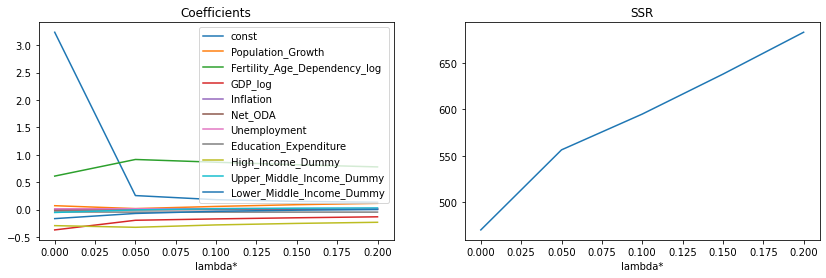

In [47]:
X = data_filtered[['Population_Growth', 'Fertility_Age_Dependency_log', 'GDP_log',
                    'Inflation', 'Net_ODA', 'Unemployment','Education_Expenditure',
                   'High_Income_Dummy','Upper_Middle_Income_Dummy','Lower_Middle_Income_Dummy']]
X = sm.add_constant(X)
y = data_filtered[['Mortality_log']]

model = sm.OLS(y, X)
results_normal_ols = model.fit()

frames = []
for a in np.arange(0, 0.25, 0.05):
    results_ridge = model.fit_regularized(L1_wt=0, alpha=a, start_params=results_normal_ols.params)
    results_ridge_fit = sm.regression.linear_model.OLSResults(model,results_ridge.params,model.normalized_cov_params)
    frames.append(np.append(results_ridge.params, results_ridge_fit.ssr))
    df = pd.DataFrame(frames, columns=list(X.columns.values) + ['ssr*'])
df.index=np.arange(0, 0.25, 0.05)
df.index.name = 'lambda*'
df.T
fig, ax = plt.subplots(1, 2, figsize=(14, 4));

ax[0] = df.iloc[:, :-1].plot(ax=ax[0])
ax[0].set_title('Coefficients')

ax[1] = df.iloc[:, -1].plot(ax=ax[1])
ax[1].set_title('SSR');

plt.savefig('lambda_selection.jpg');

We see that the value of SSR (Sum of squared errors) starts falling at alpha = 0.05. Thus we choose alpha to be 0.05 in our **Ridge Regression** model. 

Our final model and its parameters are shown below

In [48]:
results_ridge = model.fit_regularized(L1_wt=0, alpha=0.05, start_params=results_normal_ols.params)
final = sm.regression.linear_model.OLSResults(model, 
                                              results_ridge.params, 
                                              model.normalized_cov_params)
final.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          Mortality_log   R-squared:                       0.877
Model:                            OLS   Adj. R-squared:                  0.877
Method:                 Least Squares   F-statistic:                     2376.
Date:                Thu, 26 Nov 2020   Prob (F-statistic):               0.00
Time:                        22:02:28   Log-Likelihood:                -1746.6
No. Observations:                3340   AIC:                             3515.
Df Residuals:                    3329   BIC:                             3582.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
================================================================================================
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
const                            0.2552      0.148      1.725      0.085      -0.035       0.545
Population_Growth                0.0176      0.011      1.631      0.103      -0.004       0.039
Fertility_Age_Dependency_log     0.9139      0.022     42.438      0.000       0.872       0.956
GDP_log                         -0.1954      0.011    -17.286      0.000      -0.218      -0.173
Inflation                        0.0023      0.001      4.085      0.000       0.001       0.003
Net_ODA                         -0.0040      0.001     -2.953      0.003      -0.007      -0.001
Unemployment                     0.0155      0.001     12.513      0.000       0.013       0.018
Education_Expenditure           -0.0467      0.005     -9.376      0.000      -0.056      -0.037
High_Income_Dummy               -0.3237      0.036     -9.038      0.000      -0.394      -0.253
Upper_Middle_Income_Dummy       -0.0061      0.023     -0.263      0.793      -0.052       0.039
Lower_Middle_Income_Dummy       -0.0708      0.026     -2.736      0.006      -0.122      -0.020
==============================================================================
Omnibus:                        6.466   Durbin-Watson:                   0.124
Prob(Omnibus):                  0.039   Jarque-Bera (JB):                6.539
Skew:                          -0.087   Prob(JB):                       0.0380
Kurtosis:                       3.130   Cond. No.                         390.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Interpretation of the above results

The **coef** column gives us the values of the regression coefficients corresponding to all the independent variables. It can be seen from high value of regression coefficients for **Fertility_Age_Dependency_log** that the combination of **Fertility** and **Age Dependency** has a very high impact on Mortality. **GDP_log** also seems to have a high impact on Mortality but the relationship is negative. **Education_Expenditure** also has a reasonable negative impact on Mortality. **Unemployment** has a marginal positive impact on Mortality and **Inflation** and **Net ODA** seem to have almost negligible impact on Mortality. All of these regression coefficients have sufficiently large t-statistic and a low p-value which means they are significant. The coefficient for **Population Growth** is relatively low and also the t-statistic is low. The p-value is greater than 0.05 which means it is not statistically significant either.

The way we interpret the coefficients is shown below with an example considering Unemployment.

*The mean value of the log of Mortality rate under 5(per 1000 live births) changes by 0.0184 corresponding to a unit increase in the Unemployment rate (% of total labor force)*

**R-squared** signifies the amount of variability in our dependent variable is explained by our independent variables. The value of 0.867 means our model is able to explain 86.7% of variability

**F-Statistic** and the **Prob(F-Statistic)** signify the overall significance of the regression. The Null Hypothesis here being "all the regression coefficients are equal to zero". Clearly, the **Prob(F-Statistic)** is close to 0 and our **F-Statistic** has a high value indicating the regression is significant

Although, a high value of R-squared is desirable, it is also important that the residuals are normally distributed and one of the assumptions of Linear regression is Homoskedasticity, which means that the variance of residual is the same for any values of independent variables. We will analyze these aspects in the section below

<a id='residual_analysis'></a>
## Analysis of Residuals
[Back to table of contents](#contents)

Now that we have the regression coefficients calculated, we can now use them to calculated the **Estimated/Predicted Mortality** for all of our entries.

We can then analyze the difference between what the regression model predicts **Estimated/Predicted Mortality** to be and what the actual observed value of **Mortality** is. We can plot the **Residuals** using a histogram as shown below.

Note: When analyzing the residuals, we are only considering the 4 countries under our consideration

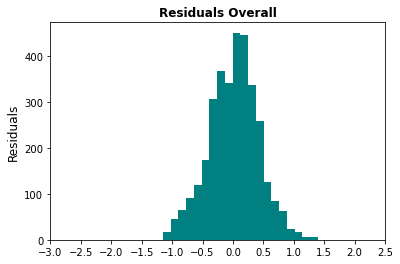

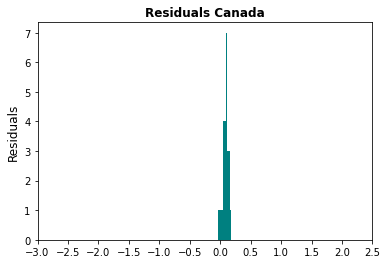

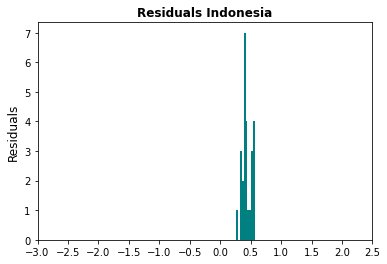

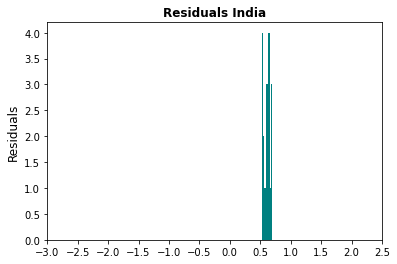

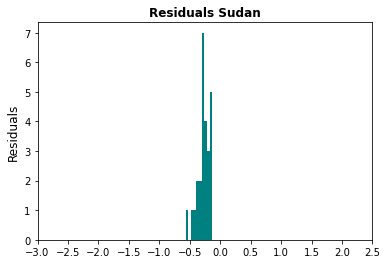

In [49]:
data_filtered['Predicted_Mortality_log'] = final.predict(X)
data_filtered['Residuals'] = data_filtered['Mortality_log'] - data_filtered['Predicted_Mortality_log']
countries = ['Canada','Indonesia','India','Sudan']
plt.figure()
plt.hist(data=data_filtered,x='Residuals',bins=20,color='teal');
plt.ylabel('Residuals',fontsize=12);
plt.title('Residuals Overall',fontsize=12,weight='bold');
plt.xticks(np.arange(-3,3,0.5));
plt.savefig('Residuals_Overall.jpg');
for i in countries:
    plt.figure()
    df=data_filtered[data_filtered['Country'] == i]
    plt.hist(data=df,x='Residuals',color='teal');
    plt.ylabel('Residuals',fontsize=12);
    plt.title('Residuals ' + i,fontsize=12,weight='bold');
    plt.xticks(np.arange(-3,3,0.5));
    plt.savefig('Residuals_' + i + '.jpg');

In addition to plotting the residuals, we can run some tests to check if our regression test has been successful.

1) First, we will test for normality of the residuals using the **Shapiro Wilk** test as shown below.

In [50]:
shapiro_wilk_results = {}
shapiro_wilk_results['Overall'] = shapiro(data_filtered['Residuals'])
#Countries under consideration
countries = ['Canada','Indonesia','India','Sudan']
for country in countries:
    residual = data_filtered[data_filtered['Country']==country].loc[:, "Residuals"]
    shapiro_wilk_test = shapiro(residual)
    shapiro_wilk_results[country] = shapiro_wilk_test
shapiro_wilk_results

{'Overall': ShapiroResult(statistic=0.9961929321289062, pvalue=1.6334146835106367e-07),
 'Canada': ShapiroResult(statistic=0.9620600938796997, pvalue=0.4336985647678375),
 'Indonesia': ShapiroResult(statistic=0.9392663836479187, pvalue=0.1289961040019989),
 'India': ShapiroResult(statistic=0.9444653391838074, pvalue=0.17162637412548065),
 'Sudan': ShapiroResult(statistic=0.9281086921691895, pvalue=0.06986723840236664)}

We can observe that the residuals are not normal for the overall data including all countries. But when we consider our 4 countries, the test says the residuals are normal for all 4 countries by failing to reject the Null hypothesis with p>0.05

2) Next, we will check for **Heteroskedasticity** in our residuals. We begin by first plotting our residual values with respect to time and also with respect to the predicted/estimated values of our dependent variable.

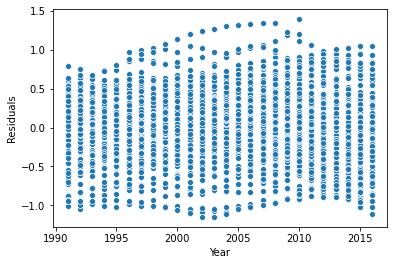

In [51]:
plt.figure()
sns.scatterplot(x='Year',y='Residuals',data = data_filtered);
plt.savefig('Scatterplot_Residuals_Year.jpg');

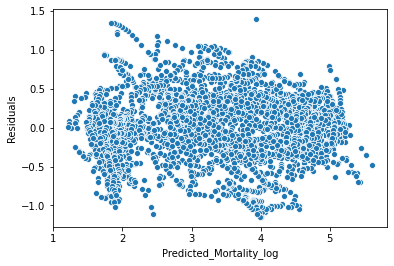

In [52]:
plt.figure()
sns.scatterplot(x='Predicted_Mortality_log',y='Residuals',data = data_filtered);
plt.savefig('Scatterplot_Residuals_Predicted.jpg');

From the plots above, it looks like our residuals do not suffer from Heteroskedasticity by a large margin because the variance in the value of residuals is not affected by the Predicted value of the dependent variable. The variance in residuals is also not constant. 

To confirm if our data has Heteroskedasticity, we can use a hypothesis test. The test we have chosen is the **Breusch Pagan** test for heteroskedasticity and is shown below. 

H<sub>0</sub>: The error(residual) variances are all equal<br>
H<sub>A</sub>: The error(residual) variances are not equal. More specifically, as X increases, the variances increase (or decrease)

In [53]:
names = ['Lagrange Multiplier statistic:', 'LM test\'s p-value:', 'F-statistic:', 'F-test\'s p-value:']

test = sms.het_breuschpagan(final.resid, final.model.exog)
lzip(names, test)

[('Lagrange Multiplier statistic:', 132.59233736671476),
 ("LM test's p-value:", 1.3812632610884348e-23),
 ('F-statistic:', 13.761889273888048),
 ("F-test's p-value:", 4.42405913934385e-24)]

According to the results of this test, we can say that our residuals suffer from Heteroskedasticity because p<0.05 which means we reject the Null hypothesis. However, the F-statistic and the Lagrange multiplier statistic values are considerably low. This means, even though the test has statistical significance, the practical impact is low.

<a id='conclusion'></a>
## Implications and Conclusion
[Back to table of contents](#contents)

Based on the regression model’s results we can say, the social and economic groups can be arranged as follows based on their impact on Child Mortality

**Household Statistics > Economy > Education > Population**

Household statistics amongst other social and economic factors have a very high correlation with Child Mortality. This means, Child Mortality has a strong relationship with both the Fertility rate in women as well as the Age Dependency Ratio.  As the Fertility rate and Age Dependency Ratio increased, so did Child Mortality. Under Economy, the only factor that has a strong relationship with Child Mortality was GDP and the relationship was negative. This meant that as GDP increased, Child Mortality decreased. Other economic factors (Inflation, Net ODA received and Unemployment) did not have a strong relationship with Child Mortality. This might be due to outliers and high degree of variance in these indices which did not correlate to a similar degree of change in Child Mortality. Education Expenditure had a weak but a considerable negative relationship with Child Mortality. Population Growth did not have a considerable relationship with Child Mortality and neither was the regression coefficient significant.

*Note: Fertility rate in women and Age Dependency ratio had a high correlation amongst themselves and so the model considered a single variable to represent both indices.*

Based on the value of residuals for each country, we can see that
a)	The regression algorithm predicted a lower value for Child Mortality than the actual value for India and Indonesia
b)	For Sudan, the predicted value was higher than what was actually observed. 
c)	For Canada, the prediction done by the multi linear regression was in line with the actual values that were observed

#### Analysis of the predicted values with respect to the independent variables

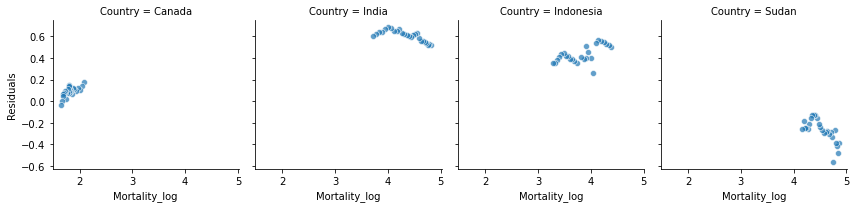

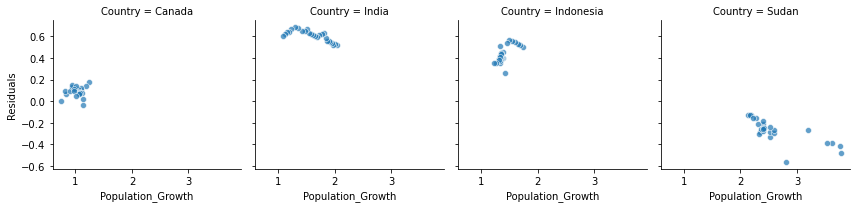

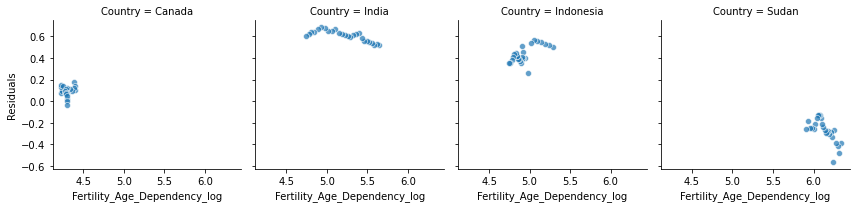

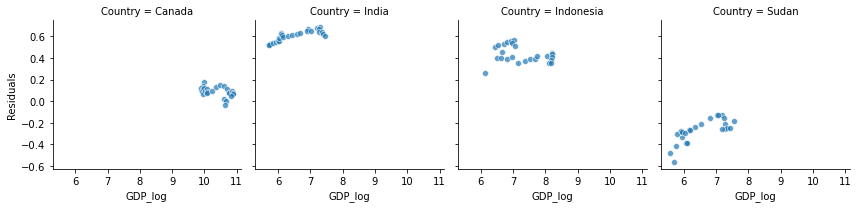

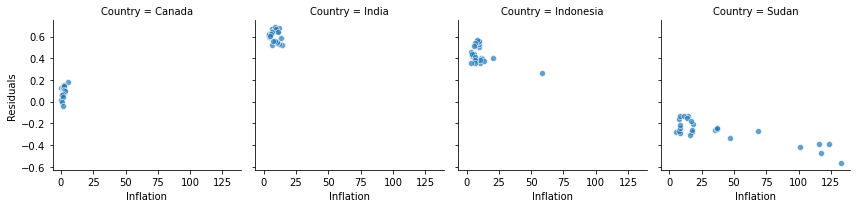

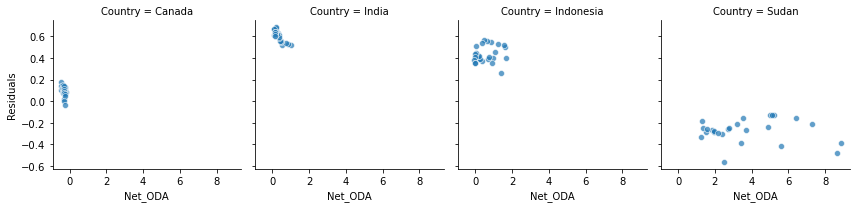

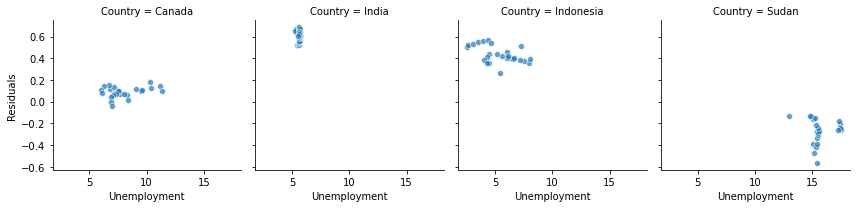

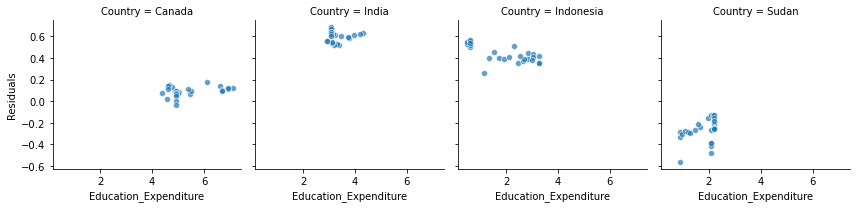

In [54]:
for i in ['Mortality_log', 'Population_Growth', 'Fertility_Age_Dependency_log', 'GDP_log', 'Inflation', 'Net_ODA', 'Unemployment',
       'Education_Expenditure']:
    g = sns.FacetGrid(data_filtered[data_filtered['Country'].isin(countries)], col="Country")
    g.map(sns.scatterplot, i, "Residuals", alpha=.7)
    plt.savefig('Residuals_vs_'+ i + '.jpg');

For instance, the above plot reveals that change in population growth does not impact the residuals much for other countries except India. This means, the regression coefficient value for Population growth is not able to explain the rise in Child Mortality with respect to the rise in Population growth in India.